In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef




def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    
    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2']
    
    return stats_data





def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=mu11, mu12=params[0], 
        mu21=mu21, mu22=params[1], 
        sigma11=params[2], sigma12=params[3], 
        sigma21=params[4], sigma22=params[5],
        j11=params[6], j12=params[7], 
        j21=params[8], j22=params[9],
        alpha=params[10], 
        beta1=beta1, beta2=beta2, 
        delta0=params[11], 
        mu1=params[12], mu2=params[13], 
        lambda11=params[14], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[14],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    
    sum_loss[0] = sum_loss[0]*50
    sum_loss[1] = sum_loss[1]*50    
    sum_loss[2] = sum_loss[2]*50
    sum_loss[3] = sum_loss[3]*50
    sum_loss[4] = sum_loss[4]*10
    sum_loss[5] = sum_loss[5]*10
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]
n_real_stats = real_stats


mu11 = 0
mu21 = 0
#alpha
beta1 = 0
beta2 = 0
#delta0
#mu1
#mu2
#lambda11 = 1
lambda12 = 0
lambda21 = 0
#lambda22 = 1


initial0 = [1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            1, 1,
            1, 1,
            1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None),
                       (None, None), (None, None), 
                       (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0  1.0  1.0

return_mean1        13617.930340
return_mean2        13018.314105
return_sd1          22072.911059
return_sd2          21190.344405
return_skew1         1823.413564
return_skew2         2280.702782
return_kurtosis1     1291.879312
return_kurtosis2     1760.161311
dtype: float64
77055.65687843307
----------
 [1]  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0  1.0  1.0

return_mean1        13448.223282
return_mean2        12848.607046
return_sd1          22611.702061
return_sd2          21820.297751
return_skew1         2091.593501
return_skew2         2570.278936
return_kurtosis1     1497.249810
return_kurtosis2     1960.315656
dtype: float64
78848.26804190557
----------
 [1]  2.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0  1.0  1.0

return_mean1        18762.138407
return_mean2        12985.584503
return_sd1          23118.867855
return_sd2          21164.060506
return_sk

return_mean1         2498.622377
return_mean2        12771.568279
return_sd1          22248.496487
return_sd2          21734.477230
return_skew1         2014.391584
return_skew2         2544.606593
return_kurtosis1     1417.503747
return_kurtosis2     1919.784420
dtype: float64
67149.45071733836
----------
 [1] -0.0004488197  1.0000000000 -1.0000000000 -1.0000000000 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         2317.020579
return_mean2        13073.994759
return_sd1          21833.731612
return_sd2          21296.285757
return_skew1         1891.275263
return_skew2         2326.283543
return_kurtosis1     1355.838815
return_kurtosis2     1811.722199
dtype: float64
65906.15252612544
----------
 [1] -0.0005488746  1.0000000000 -1.0000000000 -1.0000000000 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.

return_mean1         2548.700276
return_mean2         2348.241606
return_sd1          22095.021376
return_sd2          21304.257182
return_skew1         1875.579600
return_skew2         2422.657169
return_kurtosis1     1382.140543
return_kurtosis2     1874.153678
dtype: float64
55850.751429449854
----------
 [1] -0.0005488746  0.0257449527 -1.0000000000 -1.0000000000 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         2600.679902
return_mean2         2421.069370
return_sd1          21710.640985
return_sd2          20949.685233
return_skew1         1780.071431
return_skew2         2330.856979
return_kurtosis1     1268.036303
return_kurtosis2     1782.580330
dtype: float64
54843.62053136375
----------
 [1] -0.0005488746  0.0253303383 -1.0000000000 -1.0000000000 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1

return_mean1         1921.264402
return_mean2         2286.268697
return_sd1          11080.924095
return_sd2          21113.165431
return_skew1         2377.280151
return_skew2         2441.297450
return_kurtosis1     1747.884771
return_kurtosis2     1869.773948
dtype: float64
44837.85894491285
----------
 [1] -0.0005488746  0.0257449527 -3.6614734501 -1.0000000000 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         1861.753508
return_mean2         2328.083192
return_sd1          11227.244150
return_sd2          21254.241289
return_skew1         2301.014410
return_skew2         2416.326869
return_kurtosis1     1586.568111
return_kurtosis2     1867.094084
dtype: float64
44842.325613016656
----------
 [1] -0.0005488746  0.0257449527 -3.6346263834 -1.0000000000 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1

return_mean1         1488.748924
return_mean2         2330.693450
return_sd1           5119.091885
return_sd2          21169.799289
return_skew1         4059.804876
return_skew2         2449.031458
return_kurtosis1     3264.482971
return_kurtosis2     1794.045226
dtype: float64
41675.698078244706
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.9999999845 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         1382.733191
return_mean2         2408.645320
return_sd1           7229.672832
return_sd2          21196.776417
return_skew1         5332.496762
return_skew2         2304.330165
return_kurtosis1     5221.308179
return_kurtosis2     1747.868349
dtype: float64
46823.83121425723
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4746901368 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1

return_mean1         1579.423028
return_mean2         2427.719334
return_sd1           5201.407618
return_sd2          21218.254033
return_skew1         3766.857638
return_skew2         2488.778998
return_kurtosis1     2983.457507
return_kurtosis2     1872.650581
dtype: float64
41538.54873662619
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735017967 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         1566.817259
return_mean2         2399.019068
return_sd1           5058.058952
return_sd2          21302.687536
return_skew1         3730.296294
return_skew2         2537.897343
return_kurtosis1     3031.333355
return_kurtosis2     1882.049192
dtype: float64
41508.15899902377
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -1.0000000000
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.

return_mean1         1652.025465
return_mean2         1985.101594
return_sd1           5203.300602
return_sd2          10621.967232
return_skew1         3217.449913
return_skew2         2811.899785
return_kurtosis1     2731.538346
return_kurtosis2     2006.261195
dtype: float64
30229.5441314945
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.1914746249
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         1511.720223
return_mean2         1894.493019
return_sd1           5162.871504
return_sd2          10617.955657
return_skew1         3381.919529
return_skew2         2637.697412
return_kurtosis1     2672.614502
return_kurtosis2     1926.667433
dtype: float64
29805.939279520062
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2602513823
 [6] -1.0000000000  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.

return_mean1         1607.781877
return_mean2         2628.526554
return_sd1           4813.561648
return_sd2          22243.635592
return_skew1         3083.012856
return_skew2         2329.086907
return_kurtosis1     2311.151308
return_kurtosis2     1873.507108
dtype: float64
40890.2638513437
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2383836990  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1493.025266
return_mean2        1677.234571
return_sd1          4869.230735
return_sd2          6547.192027
return_skew1        3161.775557
return_skew2        3004.764533
return_kurtosis1    2294.182188
return_kurtosis2    2169.566100
dtype: float64
25216.97097688909
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2729665264  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.000000000

return_mean1        1491.756697
return_mean2        1652.667942
return_sd1          4867.451916
return_sd2          6602.999222
return_skew1        3462.233459
return_skew2        3164.173342
return_kurtosis1    2854.949622
return_kurtosis2    2486.984160
dtype: float64
26583.216360291815
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473395332  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1530.211254
return_mean2        1705.525709
return_sd1          5504.238888
return_sd2          6648.916679
return_skew1        3565.118216
return_skew2        3366.740000
return_kurtosis1    2908.390169
return_kurtosis2    2444.922781
dtype: float64
27674.0636970065
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2474289012  0.1000000000  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.00

return_mean1        1550.367134
return_mean2        1789.771521
return_sd1          4610.415796
return_sd2          6644.751209
return_skew1        2539.539743
return_skew2        3308.916352
return_kurtosis1    1782.710305
return_kurtosis2    2498.996513
dtype: float64
24725.468574157272
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163770998  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1547.243825
return_mean2        1745.978351
return_sd1          4616.303943
return_sd2          6520.634083
return_skew1        2574.044783
return_skew2        2928.822147
return_kurtosis1    1843.924258
return_kurtosis2    2186.280625
dtype: float64
23963.232014059024
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0162921289  0.1000000000  0.1000000000  0.1000000000
[11]  1.0000000000  1.

return_mean1        1547.775552
return_mean2        1706.535503
return_sd1          4547.399931
return_sd2          6518.193456
return_skew1        1694.152380
return_skew2        3144.263300
return_kurtosis1    1264.943215
return_kurtosis2    2190.930444
dtype: float64
22614.193780625326
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367  0.0020905008  0.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1456.887968
return_mean2        1600.817555
return_sd1          4465.446213
return_sd2          6836.400549
return_skew1        1648.803484
return_skew2        3572.034506
return_kurtosis1    1280.773528
return_kurtosis2    2759.103705
dtype: float64
23620.267507976234
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0092614856  0.1000000000  0.1000000000
[11]  1.0000000000  1.

return_mean1        1548.744756
return_mean2        1753.274400
return_sd1          4575.660905
return_sd2          6855.617140
return_skew1        1715.839996
return_skew2        3247.919428
return_kurtosis1    1300.093392
return_kurtosis2    2522.240561
dtype: float64
23519.390577821046
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727  1.1000000000  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1         1501.428782
return_mean2         6005.592313
return_sd1           4572.873988
return_sd2          55750.417863
return_skew1         1652.806625
return_skew2        13241.378224
return_kurtosis1     1266.413260
return_kurtosis2    15876.614026
dtype: float64
99867.52508132123
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -1.5180340000  0.1000000000
[11]  1.0000000

return_mean1        1539.732489
return_mean2        1666.266759
return_sd1          4474.721441
return_sd2          6041.045558
return_skew1        1645.757986
return_skew2        2540.450372
return_kurtosis1    1272.977027
return_kurtosis2    1889.340864
dtype: float64
21070.292494880807
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.1000000000
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1472.108546
return_mean2        1602.647336
return_sd1          4477.287332
return_sd2          5982.578875
return_skew1        1679.849807
return_skew2        2530.430516
return_kurtosis1    1270.959926
return_kurtosis2    1879.141928
dtype: float64
20895.004266406107
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0236003799  0.1000000000
[11]  1.0000000000  1.

return_mean1        1520.363906
return_mean2        1794.964501
return_sd1          4435.079040
return_sd2          5372.998720
return_skew1        1644.514125
return_skew2        2181.226421
return_kurtosis1    1271.329718
return_kurtosis2    1804.585549
dtype: float64
20025.06197975207
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0033563220
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1414.591418
return_mean2        1730.135858
return_sd1          4447.158733
return_sd2          5394.169114
return_skew1        1650.265088
return_skew2        2210.953582
return_kurtosis1    1270.518448
return_kurtosis2    1805.342827
dtype: float64
19923.1350684169
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0247749591
[11]  1.0000000000  1.000

return_mean1        1527.878775
return_mean2        1773.841145
return_sd1          4455.361952
return_sd2          5546.147323
return_skew1        1635.648040
return_skew2        2237.171404
return_kurtosis1    1265.389545
return_kurtosis2    1792.213305
dtype: float64
20233.651489174907
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0254076507
[11]  1.0000000000  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1527.776076
return_mean2        1715.269262
return_sd1          4372.380033
return_sd2          5439.439012
return_skew1        1680.464163
return_skew2        2283.700083
return_kurtosis1    1271.060465
return_kurtosis2    1791.443623
dtype: float64
20081.53271692607
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253735659
[11]  1.0000000000  1.0

return_mean1        1446.253972
return_mean2        1687.258433
return_sd1          4487.274370
return_sd2          5475.049339
return_skew1        1658.797311
return_skew2        2198.115372
return_kurtosis1    1276.390808
return_kurtosis2    1808.920668
dtype: float64
20038.060273865005
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6147092813  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1496.020596
return_mean2        1726.091765
return_sd1          4525.705590
return_sd2          5451.909516
return_skew1        1628.343419
return_skew2        2208.238082
return_kurtosis1    1274.862154
return_kurtosis2    1808.250857
dtype: float64
20119.421980001986
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6046721349  1.

return_mean1        1529.158281
return_mean2        1820.723258
return_sd1          4427.948597
return_sd2          5517.175251
return_skew1        1649.898179
return_skew2        2198.676605
return_kurtosis1    1274.114479
return_kurtosis2    1804.292017
dtype: float64
20221.98666750794
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084613842  1.0000000000  1.0000000000  1.0000000000  1.0000000000

return_mean1        1636.237836
return_mean2        1910.276871
return_sd1          4558.566538
return_sd2          5466.546035
return_skew1        1673.979342
return_skew2        2189.060980
return_kurtosis1    1273.821524
return_kurtosis2    1804.607303
dtype: float64
20513.096428619298
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084659271  1.0

return_mean1        1312.760405
return_mean2        1575.042037
return_sd1          4416.584236
return_sd2          5444.661275
return_skew1        1640.610511
return_skew2        2202.701439
return_kurtosis1    1272.638520
return_kurtosis2    1803.203092
dtype: float64
19668.20151631446
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1577046078  1.0000000000  1.0000000000  1.0000000000

return_mean1        1616.473072
return_mean2        1941.993789
return_sd1          4393.851586
return_sd2          5346.183954
return_skew1        1653.737336
return_skew2        2232.803284
return_kurtosis1    1273.365529
return_kurtosis2    1804.875511
dtype: float64
20263.284059863065
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1

return_mean1        1511.798595
return_mean2        1795.193793
return_sd1          4463.343220
return_sd2          5448.215705
return_skew1        1633.247110
return_skew2        2226.799186
return_kurtosis1    1273.713911
return_kurtosis2    1806.556749
dtype: float64
20158.868268450817
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1556196230  1.0000000000  1.0000000000  1.0000000000

return_mean1        1364.391896
return_mean2        1709.244632
return_sd1          4413.160869
return_sd2          5462.336831
return_skew1        1650.527513
return_skew2        2183.925225
return_kurtosis1    1277.958027
return_kurtosis2    1810.948924
dtype: float64
19872.493918165033
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.

return_mean1        1514.942015
return_mean2        1774.813294
return_sd1          4488.954541
return_sd2          5573.651057
return_skew1        1683.238935
return_skew2        2219.998280
return_kurtosis1    1263.177855
return_kurtosis2    1795.309160
dtype: float64
20314.08513693274
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1556204577  0.6276302364  1.0000000000  1.0000000000

return_mean1        1494.342229
return_mean2        1757.051967
return_sd1          4447.901446
return_sd2          5475.765191
return_skew1        1649.267152
return_skew2        2168.453580
return_kurtosis1    1277.155357
return_kurtosis2    1806.525878
dtype: float64
20076.462799755678
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1

return_mean1        1468.823453
return_mean2        1715.683045
return_sd1          4534.528477
return_sd2          5437.445797
return_skew1        1675.473386
return_skew2        2221.972204
return_kurtosis1    1277.350561
return_kurtosis2    1808.513418
dtype: float64
20139.790340857635
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1556204577  0.6180339904  1.0000000000  1.0000000000

return_mean1        1519.151347
return_mean2        1717.984059
return_sd1          4449.919839
return_sd2          5353.772250
return_skew1        1663.027456
return_skew2        2224.936518
return_kurtosis1    1269.182601
return_kurtosis2    1799.794603
dtype: float64
19997.76867335413
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1

return_mean1        1485.550046
return_mean2        1675.910619
return_sd1          4461.962201
return_sd2          5287.619149
return_skew1        1683.251395
return_skew2        2213.976175
return_kurtosis1    1269.594080
return_kurtosis2    1804.151726
dtype: float64
19882.01539196317
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1556204577  0.6180339904  1.3906396463  1.0000000000

return_mean1        1588.339623
return_mean2        1780.602447
return_sd1          4543.325445
return_sd2          5557.436136
return_skew1        1662.414271
return_skew2        2219.373476
return_kurtosis1    1277.167565
return_kurtosis2    1806.495059
dtype: float64
20435.154022126877
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1

return_mean1        1405.459230
return_mean2        1723.015207
return_sd1          4394.809253
return_sd2          5287.829139
return_skew1        1680.570743
return_skew2        2212.487131
return_kurtosis1    1269.377332
return_kurtosis2    1799.887155
dtype: float64
19773.435189641757
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1556204577  0.6180339904  1.3903508563  2.6248374368

return_mean1        1495.570810
return_mean2        1706.606664
return_sd1          4500.134542
return_sd2          5497.096951
return_skew1        1667.676311
return_skew2        2194.336057
return_kurtosis1    1274.139120
return_kurtosis2    1806.091176
dtype: float64
20141.651630872126
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.

return_mean1        1460.950815
return_mean2        1616.033701
return_sd1          4424.201494
return_sd2          5455.496946
return_skew1        1631.281083
return_skew2        2197.482445
return_kurtosis1    1272.466177
return_kurtosis2    1803.240695
dtype: float64
19861.153356450068
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.1556204577  0.6180339904  1.3903508563  2.6085026805

return_mean1        1414.878651
return_mean2        1666.641059
return_sd1          4412.035656
return_sd2          5460.897882
return_skew1        1630.826693
return_skew2        2171.152620
return_kurtosis1    1263.886540
return_kurtosis2    1796.399964
dtype: float64
19816.719065376317
----------
 [1] -0.0005488746  0.0257449527 -3.6174472336 -1.4735491516 -5.2360680252
 [6] -1.2473947657  0.0163687367 -0.0053441727 -0.0237958392  0.0253865851
[11]  2.6084641918  1.

return_mean1        1493.330385
return_mean2        1749.121572
return_sd1          4535.674531
return_sd2          5477.046089
return_skew1        1658.261045
return_skew2        2228.310735
return_kurtosis1    1282.433450
return_kurtosis2    1812.677117
dtype: float64
20236.854923773757
----------
 [1] -0.010925985  0.025744953 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1298.215492
return_mean2        1584.163859
return_sd1          4495.290491
return_sd2          5408.566146
return_skew1        1664.839695
return_skew2        2213.847552
return_kurtosis1    1274.064694
return_kurtosis2    1802.867323
dtype: float64
19741.855252026213
----------
 [1] -0.017339392  0.025744953 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.

return_mean1        1437.994093
return_mean2        1698.919971
return_sd1          4471.711290
return_sd2          5446.332164
return_skew1        1668.558556
return_skew2        2170.199095
return_kurtosis1    1278.667885
return_kurtosis2    1800.746611
dtype: float64
19973.129664914566
----------
 [1] -0.010927142  0.025744953 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1439.286233
return_mean2        1667.109562
return_sd1          4503.321370
return_sd2          5334.231710
return_skew1        1675.543457
return_skew2        2214.384404
return_kurtosis1    1273.507097
return_kurtosis2    1798.132433
dtype: float64
19905.516265307153
----------
 [1] -0.010925985  0.025744953 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.

return_mean1        1450.793243
return_mean2        1668.341975
return_sd1          4506.541912
return_sd2          5565.725786
return_skew1        1628.243631
return_skew2        2180.012779
return_kurtosis1    1278.021648
return_kurtosis2    1804.132160
dtype: float64
20081.813135265656
----------
 [1] -0.010925985  0.029107332 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1382.529381
return_mean2        1679.354383
return_sd1          4498.082484
return_sd2          5450.243626
return_skew1        1673.104053
return_skew2        2208.849754
return_kurtosis1    1270.527163
return_kurtosis2    1796.974274
dtype: float64
19959.66511628001
----------
 [1] -0.010925985  0.028068300 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1386.300113
return_mean2        1728.788228
return_sd1          4478.126912
return_sd2          5477.963213
return_skew1        1676.402636
return_skew2        2243.074539
return_kurtosis1    1278.739911
return_kurtosis2    1800.278581
dtype: float64
20069.674133909466
----------
 [1] -0.010925985  0.028465175 -3.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1457.663254
return_mean2        1775.886699
return_sd1          4527.157241
return_sd2          5497.785923
return_skew1        1641.805119
return_skew2        2201.031143
return_kurtosis1    1276.292224
return_kurtosis2    1805.562264
dtype: float64
20183.18386870026
----------
 [1] -0.010925985  0.028465175 -2.617447234 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1372.319406
return_mean2        1614.458610
return_sd1          4448.237792
return_sd2          5511.662976
return_skew1        1687.622781
return_skew2        2194.708689
return_kurtosis1    1273.748282
return_kurtosis2    1801.130574
dtype: float64
19903.889110009757
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1430.094026
return_mean2        1659.004024
return_sd1          4402.559229
return_sd2          5306.579606
return_skew1        1628.598319
return_skew2        2203.518741
return_kurtosis1    1261.505093
return_kurtosis2    1784.376413
dtype: float64
19676.23545031213
----------
 [1] -0.010925985  0.028465175 -2.763259849 -0.473549152 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1420.704323
return_mean2        1631.458337
return_sd1          4429.977442
return_sd2          5411.423892
return_skew1        1663.852045
return_skew2        2208.006895
return_kurtosis1    1267.295286
return_kurtosis2    1797.342638
dtype: float64
19830.06085677945
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467166842 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1382.344493
return_mean2        1710.837049
return_sd1          4411.576433
return_sd2          5402.868469
return_skew1        1659.733592
return_skew2        2179.667227
return_kurtosis1    1272.840881
return_kurtosis2    1802.208025
dtype: float64
19822.07616846291
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467316161 -5.236068025
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.39

return_mean1        1457.832411
return_mean2        1664.997534
return_sd1          4373.379458
return_sd2          5432.286561
return_skew1        1640.137025
return_skew2        2206.005202
return_kurtosis1    1269.883959
return_kurtosis2    1801.604787
dtype: float64
19846.1269376399
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.326237952
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1513.181667
return_mean2        1735.577246
return_sd1          4411.475720
return_sd2          5446.511740
return_skew1        1676.747064
return_skew2        2182.409476
return_kurtosis1    1267.560974
return_kurtosis2    1799.686866
dtype: float64
20033.150752886133
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.180339923
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.39

return_mean1         1442.100001
return_mean2         3126.294137
return_sd1           4379.521934
return_sd2          40146.840354
return_skew1         1657.718838
return_skew2         2207.869032
return_kurtosis1     1268.778925
return_kurtosis2     1807.634113
dtype: float64
56036.75733409848
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -2.865428766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1         1528.947361
return_mean2         1370.601229
return_sd1           4303.922718
return_sd2          16176.727437
return_skew1         1695.175784
return_skew2         3210.331722
return_kurtosis1     1269.979906
return_kurtosis2     2251.961990
dtype: float64
31807.64814656618
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.247394766  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0

return_mean1        1432.953247
return_mean2        1632.023933
return_sd1          4257.318569
return_sd2          5008.902455
return_skew1        1719.426932
return_skew2        2211.764671
return_kurtosis1    1272.160056
return_kurtosis2    1800.263859
dtype: float64
19334.813721325
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.359871960  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1430.648435
return_mean2        1660.173130
return_sd1          4505.434038
return_sd2          5011.133031
return_skew1        1637.014343
return_skew2        2185.331313
return_kurtosis1    1277.998116
return_kurtosis2    1806.526443
dtype: float64
19514.258849708945
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361363796  0.016368737 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390

return_mean1         2462.168930
return_mean2         1644.811679
return_sd1          17074.950858
return_sd2           4980.253776
return_skew1         7407.572037
return_skew2         2208.611782
return_kurtosis1     7645.037053
return_kurtosis2     1804.035631
dtype: float64
45227.441745882235
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.031709172 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1432.590480
return_mean2        1617.692137
return_sd1          4282.832897
return_sd2          4930.881490
return_skew1        1667.064684
return_skew2        2219.111097
return_kurtosis1    1257.196517
return_kurtosis2    1795.536159
dtype: float64
19202.90545983086
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.025736421 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033

return_mean1        1576.861517
return_mean2        1796.018258
return_sd1          4427.714224
return_sd2          4917.215809
return_skew1        1695.616932
return_skew2        2204.155737
return_kurtosis1    1266.201811
return_kurtosis2    1796.156700
dtype: float64
19679.94098800648
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029397771 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1484.621916
return_mean2        1624.267956
return_sd1          4386.223342
return_sd2          4833.070615
return_skew1        1657.037079
return_skew2        2236.816800
return_kurtosis1    1270.368759
return_kurtosis2    1803.231391
dtype: float64
19295.637856435656
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029442054 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1450.263801
return_mean2        1623.218749
return_sd1          4361.553388
return_sd2          4962.163637
return_skew1        1663.639039
return_skew2        2183.010557
return_kurtosis1    1261.690978
return_kurtosis2    1790.929309
dtype: float64
19296.46945732383
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.001931871 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1424.811236
return_mean2        1668.382428
return_sd1          4419.921506
return_sd2          4973.369609
return_skew1        1669.635185
return_skew2        2202.401248
return_kurtosis1    1267.892347
return_kurtosis2    1813.122915
dtype: float64
19439.536474928944
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.007407613 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1500.222448
return_mean2        1701.073881
return_sd1          4400.975353
return_sd2          4968.590370
return_skew1        1630.993562
return_skew2        2190.139292
return_kurtosis1    1263.569196
return_kurtosis2    1800.760199
dtype: float64
19456.324300679687
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005343552 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1533.361168
return_mean2        1617.079964
return_sd1          4333.609518
return_sd2          4902.325213
return_skew1        1656.981961
return_skew2        2209.627547
return_kurtosis1    1260.404810
return_kurtosis2    1798.914250
dtype: float64
19312.304430568176
----------
 [1] -0.01092598  0.02846517 -2.76325985 -1.46707456 -6.23606801 -1.36101162
 [7] -0.02942778 -0.00534453 -0.02379584  0.02538659  2.60846419  1.15562046
[13]  0.61803399  1.39035086  2.6

return_mean1        1468.912168
return_mean2        1598.361518
return_sd1          4371.880495
return_sd2          5017.520819
return_skew1        1677.189231
return_skew2        2160.520188
return_kurtosis1    1269.661321
return_kurtosis2    1803.647968
dtype: float64
19367.69370698081
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1503.118862
return_mean2        1612.827600
return_sd1          4325.354807
return_sd2          4991.428950
return_skew1        1631.359166
return_skew2        2188.244303
return_kurtosis1    1255.970540
return_kurtosis2    1794.529153
dtype: float64
19302.833381363405
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.023795839  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1464.606772
return_mean2        1609.468396
return_sd1          4372.970446
return_sd2          4996.273742
return_skew1        1662.655477
return_skew2        2224.506220
return_kurtosis1    1268.552903
return_kurtosis2    1783.176943
dtype: float64
19382.210899961716
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.031824229  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1484.062444
return_mean2        1650.103846
return_sd1          4374.814616
return_sd2          4946.571259
return_skew1        1650.975331
return_skew2        2228.734828
return_kurtosis1    1272.680685
return_kurtosis2    1801.345047
dtype: float64
19409.288056232974
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.039764484  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.

return_mean1        1476.984241
return_mean2        1645.686599
return_sd1          4353.962686
return_sd2          4949.378932
return_skew1        1653.214524
return_skew2        2209.577206
return_kurtosis1    1259.173542
return_kurtosis2    1775.987359
dtype: float64
19323.965089544807
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1335.572626
return_mean2        1530.013655
return_sd1          4404.255595
return_sd2          4997.986267
return_skew1        1706.403129
return_skew2        2225.719681
return_kurtosis1    1257.583661
return_kurtosis2    1786.399763
dtype: float64
19243.93437669713
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.025386585
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1433.569940
return_mean2        1614.783148
return_sd1          4341.122295
return_sd2          4857.192649
return_skew1        1639.793694
return_skew2        2240.461920
return_kurtosis1    1269.428871
return_kurtosis2    1782.351829
dtype: float64
19178.70434529976
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.007150165
[11]  2.608464192  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1481.426329
return_mean2        1569.655934
return_sd1          4377.021785
return_sd2          4983.454317
return_skew1        1659.102409
return_skew2        2269.713249
return_kurtosis1    1247.866592
return_kurtosis2    1762.710330
dtype: float64
19350.950945066397
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.010146650
[11]  2.608464192  1.155620458  0.618033990  1.3

return_mean1        1446.404161
return_mean2        1734.374436
return_sd1          4402.922148
return_sd2          4954.763573
return_skew1        1645.104843
return_skew2        2264.636784
return_kurtosis1    1265.009278
return_kurtosis2    1793.217562
dtype: float64
19506.43278353913
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  3.168672896  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1466.559053
return_mean2        1764.124182
return_sd1          4353.010343
return_sd2          4954.177376
return_skew1        1682.250644
return_skew2        2236.048557
return_kurtosis1    1276.977636
return_kurtosis2    1799.605946
dtype: float64
19532.753737669635
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.155620458  0.618033990  1.3

return_mean1        1449.294592
return_mean2        1658.025447
return_sd1          4433.643595
return_sd2          4961.371381
return_skew1        1672.470834
return_skew2        2237.157794
return_kurtosis1    1260.567388
return_kurtosis2    1792.635015
dtype: float64
19465.166044305584
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996296299  1.155620458  0.618033990  1.390350856  2.608495330

return_mean1        1478.088493
return_mean2        1697.536109
return_sd1          4392.533831
return_sd2          4947.736267
return_skew1        1716.387421
return_skew2        2220.520934
return_kurtosis1    1255.864035
return_kurtosis2    1774.036162
dtype: float64
19482.703252908264
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.995888093  1.155620458  0.618033990  1.

return_mean1        1565.769222
return_mean2        1730.626476
return_sd1          4357.289152
return_sd2          5081.894677
return_skew1        1700.099741
return_skew2        2220.689224
return_kurtosis1    1256.173944
return_kurtosis2    1781.750012
dtype: float64
19694.29244900817
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.363873982  0.618033990  1.390350856  2.608495330

return_mean1        1588.728051
return_mean2        1737.680732
return_sd1          4486.430647
return_sd2          4996.717641
return_skew1        1682.172112
return_skew2        2281.337089
return_kurtosis1    1280.475575
return_kurtosis2    1798.791818
dtype: float64
19852.333663983634
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.090252833  0.618033990  1.3

return_mean1        1458.680948
return_mean2        1653.596822
return_sd1          4345.757424
return_sd2          4973.315066
return_skew1        1723.785344
return_skew2        2234.971766
return_kurtosis1    1251.527688
return_kurtosis2    1771.140455
dtype: float64
19412.775513340588
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253356151  0.618033990  1.390350856  2.608495330

return_mean1        1559.371102
return_mean2        1766.541396
return_sd1          4391.960351
return_sd2          4955.374670
return_skew1        1712.545780
return_skew2        2232.804257
return_kurtosis1    1268.300488
return_kurtosis2    1803.248190
dtype: float64
19690.146233828607
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253188892  0.618033990  1.

return_mean1        1481.340162
return_mean2        1706.121497
return_sd1          4318.881621
return_sd2          4909.337117
return_skew1        1652.108097
return_skew2        2226.951876
return_kurtosis1    1262.085544
return_kurtosis2    1780.945232
dtype: float64
19337.77114500959
----------
 [1] -1.092598e-02  2.846517e-02 -2.763260e+00 -1.467075e+00 -6.236068e+00
 [6] -1.361012e+00 -2.942778e-02 -5.344173e-03 -3.785672e-02  9.668693e-03
[11]  1.996044e+00  1.253266e+00  1.554726e-08  1.390351e+00  2.608495e+00

return_mean1        1462.108315
return_mean2        1672.047588
return_sd1          4324.051359
return_sd2          5016.235637
return_skew1        1688.025618
return_skew2        2233.548927
return_kurtosis1    1243.276675
return_kurtosis2    1769.733051
dtype: float64
19409.027169383095
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0

return_mean1        1571.485709
return_mean2        1806.318119
return_sd1          4337.081307
return_sd2          4964.974771
return_skew1        1662.494210
return_skew2        2231.228365
return_kurtosis1    1259.496938
return_kurtosis2    1773.228439
dtype: float64
19606.307857683383
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  1.000106954  1.390350856  2.608495330

return_mean1        1519.169828
return_mean2        1671.442860
return_sd1          4456.818730
return_sd2          4943.983433
return_skew1        1656.533692
return_skew2        2248.150224
return_kurtosis1    1237.991185
return_kurtosis2    1766.366211
dtype: float64
19500.456161896604
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999893592  1.

return_mean1        1447.373246
return_mean2        1768.839948
return_sd1          4318.288703
return_sd2          4905.441470
return_skew1        1675.069591
return_skew2        2213.049075
return_kurtosis1    1259.668512
return_kurtosis2    1784.242411
dtype: float64
19371.97295485049
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.169944472  2.608495330

return_mean1        1506.585339
return_mean2        1676.095300
return_sd1          4372.506857
return_sd2          5004.348531
return_skew1        1692.043096
return_skew2        2282.651229
return_kurtosis1    1229.382803
return_kurtosis2    1754.171118
dtype: float64
19517.784272078912
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.2

return_mean1        1414.355413
return_mean2        1653.709167
return_sd1          4386.250622
return_sd2          4934.091593
return_skew1        1677.644587
return_skew2        2248.960881
return_kurtosis1    1259.121098
return_kurtosis2    1795.109997
dtype: float64
19369.243357043688
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.360259463

return_mean1        1421.119132
return_mean2        1789.868017
return_sd1          4387.920557
return_sd2          5003.905363
return_skew1        1678.624890
return_skew2        2253.091902
return_kurtosis1    1265.433469
return_kurtosis2    1792.982775
dtype: float64
19592.946105958785
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1        1485.444594
return_mean2        1641.544469
return_sd1          4339.371919
return_sd2          4998.445599
return_skew1        1677.753195
return_skew2        2277.592301
return_kurtosis1    1272.245758
return_kurtosis2    1788.985068
dtype: float64
19481.38290397561
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449654870

return_mean1        1494.464235
return_mean2        1823.372982
return_sd1          4493.117107
return_sd2          4975.053848
return_skew1        1672.074479
return_skew2        2174.115057
return_kurtosis1    1262.219790
return_kurtosis2    1797.272061
dtype: float64
19691.689559827362
----------
 [1] -0.010925985  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.1

return_mean1        1530.575004
return_mean2        1838.715418
return_sd1          4341.255296
return_sd2          4927.842504
return_skew1        1662.884097
return_skew2        2206.746662
return_kurtosis1    1269.913196
return_kurtosis2    1792.090402
dtype: float64
19570.022579713368
----------
 [1] -0.246993950  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        5304.366237
return_mean2        1756.121849
return_sd1          4311.758940
return_sd2          4978.001013
return_skew1        1631.099037
return_skew2        2229.383627
return_kurtosis1    1264.859998
return_kurtosis2    1795.884608
dtype: float64
23271.47531012986
----------
 [1] -0.068340604  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.1

return_mean1        1559.814333
return_mean2        1921.203061
return_sd1          4436.438201
return_sd2          4931.638576
return_skew1        1670.469826
return_skew2        2238.858416
return_kurtosis1    1271.005449
return_kurtosis2    1787.457559
dtype: float64
19816.885422170766
----------
 [1] -0.010930409  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1499.280702
return_mean2        1746.989857
return_sd1          4397.826898
return_sd2          5000.117764
return_skew1        1666.880034
return_skew2        2197.351658
return_kurtosis1    1267.351159
return_kurtosis2    1793.865103
dtype: float64
19569.663175599148
----------
 [1] -0.010930832  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1         1504.621368
return_mean2        80126.706500
return_sd1           4436.460296
return_sd2          20913.964325
return_skew1         1678.279256
return_skew2         2718.442359
return_kurtosis1     1264.259651
return_kurtosis2     1926.781254
dtype: float64
114569.51500974536
----------
 [1] -0.010930675  0.028465175 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1525.751843
return_mean2        1720.953028
return_sd1          4455.140392
return_sd2          4925.454248
return_skew1        1693.964823
return_skew2        2206.465476
return_kurtosis1    1257.971489
return_kurtosis2    1774.874389
dtype: float64
19560.575689604637
----------
 [1] -0.010930675 -0.589568800 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.99999

return_mean1        1553.138527
return_mean2        1600.818724
return_sd1          4373.592377
return_sd2          4873.937559
return_skew1        1645.355040
return_skew2        2192.439730
return_kurtosis1    1264.412941
return_kurtosis2    1795.719375
dtype: float64
19299.414273488896
----------
 [1] -0.010930675 -0.037431488 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1441.022178
return_mean2        1450.091239
return_sd1          4444.711159
return_sd2          4976.382068
return_skew1        1651.662573
return_skew2        2228.244471
return_kurtosis1    1271.522534
return_kurtosis2    1793.909955
dtype: float64
19257.54617669524
----------
 [1] -0.010930675 -0.038032854 -2.763259849 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.1

return_mean1        1461.062312
return_mean2        1442.657888
return_sd1          4407.427127
return_sd2          5001.048254
return_skew1        1646.149108
return_skew2        2261.885951
return_kurtosis1    1266.995895
return_kurtosis2    1787.202210
dtype: float64
19274.428745731835
----------
 [1] -0.010930675 -0.037809850 -3.644386809 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1502.935091
return_mean2        1554.257297
return_sd1          4413.934313
return_sd2          4926.206551
return_skew1        1665.825164
return_skew2        2235.113870
return_kurtosis1    1256.961979
return_kurtosis2    1778.789503
dtype: float64
19334.023768665833
----------
 [1] -0.010930675 -0.037809850 -3.707370656 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1         1196.300136
return_mean2         1563.174811
return_sd1          15691.983616
return_sd2           5030.157430
return_skew1         2674.224953
return_skew2         2248.050744
return_kurtosis1     1771.946969
return_kurtosis2     1780.619255
dtype: float64
31956.457913230362
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.467074557 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1541.577202
return_mean2        1566.616989
return_sd1          4527.454353
return_sd2          4940.099563
return_skew1        1658.572927
return_skew2        2175.865958
return_kurtosis1    1267.025217
return_kurtosis2    1780.535211
dtype: float64
19457.747420056312
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -2.085108532 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.99999

return_mean1        1658.827655
return_mean2        1506.457724
return_sd1          4256.799760
return_sd2          5048.089550
return_skew1        1680.903263
return_skew2        2204.798189
return_kurtosis1    1264.163158
return_kurtosis2    1797.674232
dtype: float64
19417.713532874295
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.401442929 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1495.474898
return_mean2        1546.241134
return_sd1          4296.194988
return_sd2          4923.948224
return_skew1        1625.566466
return_skew2        2245.768455
return_kurtosis1    1271.004989
return_kurtosis2    1797.482313
dtype: float64
19201.681467708775
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.401063291 -6.236068010
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1        1534.791620
return_mean2        1556.936209
return_sd1          4341.582622
return_sd2          4988.566638
return_skew1        1683.220159
return_skew2        2204.871159
return_kurtosis1    1272.402779
return_kurtosis2    1801.729280
dtype: float64
19384.100465480984
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.045799324
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1552.311266
return_mean2        1494.186590
return_sd1          4386.180139
return_sd2          4999.663154
return_skew1        1691.639708
return_skew2        2265.207527
return_kurtosis1    1253.597181
return_kurtosis2    1777.151905
dtype: float64
19419.937470337303
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.163391841
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1        1479.370241
return_mean2        1534.261256
return_sd1          4388.701097
return_sd2          4895.479397
return_skew1        1618.096575
return_skew2        2184.204730
return_kurtosis1    1262.535765
return_kurtosis2    1795.918679
dtype: float64
19158.567740358856
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236439171
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1560.478736
return_mean2        1526.964602
return_sd1          4418.279282
return_sd2          4970.972260
return_skew1        1686.989932
return_skew2        2209.721547
return_kurtosis1    1265.453366
return_kurtosis2    1777.220731
dtype: float64
19416.08045584877
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236431373
 [6] -1.361011621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.1

return_mean1         1617.537346
return_mean2         1290.589504
return_sd1           4322.287004
return_sd2          10072.084576
return_skew1         1655.814411
return_skew2         2413.858210
return_kurtosis1     1269.222139
return_kurtosis2     1775.900909
dtype: float64
24417.294097331644
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -0.979045621 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1569.880071
return_mean2        1890.888414
return_sd1          4390.825560
return_sd2          9674.118232
return_skew1        1654.954592
return_skew2        2210.896226
return_kurtosis1    1252.235185
return_kurtosis2    1792.257212
dtype: float64
24436.05549179366
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.479475507 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999

return_mean1        1538.341290
return_mean2        1646.716973
return_sd1          4434.603682
return_sd2          5015.116301
return_skew1        1661.489615
return_skew2        2183.688079
return_kurtosis1    1264.555528
return_kurtosis2    1789.328798
dtype: float64
19533.840265912426
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.029427784 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1469.421420
return_mean2        1622.529356
return_sd1          4360.276033
return_sd2          4998.355085
return_skew1        1645.464267
return_skew2        2198.266323
return_kurtosis1    1261.442094
return_kurtosis2    1784.704091
dtype: float64
19340.458668647338
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477  0.970572216 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1        1564.882508
return_mean2        1651.897468
return_sd1          4320.248121
return_sd2          5012.320833
return_skew1        1641.447548
return_skew2        2215.766511
return_kurtosis1    1271.930809
return_kurtosis2    1793.887755
dtype: float64
19472.381554646236
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.019613518 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1577.919625
return_mean2        1610.913535
return_sd1          4320.282044
return_sd2          4898.526327
return_skew1        1684.315880
return_skew2        2221.314159
return_kurtosis1    1267.576052
return_kurtosis2    1781.745331
dtype: float64
19362.59295223522
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020494632 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.1

return_mean1         3805.451782
return_mean2         1498.103223
return_sd1          55011.618054
return_sd2           5067.319012
return_skew1         9370.486314
return_skew2         2154.782752
return_kurtosis1    11779.849639
return_kurtosis2     1786.962126
dtype: float64
90474.57290259755
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.005344173 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1524.594024
return_mean2        1578.959965
return_sd1          4298.847732
return_sd2          5060.463062
return_skew1        1649.109420
return_skew2        2242.396212
return_kurtosis1    1274.527060
return_kurtosis2    1790.648183
dtype: float64
19419.545658794596
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.623378148 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999

return_mean1        1508.880989
return_mean2        1478.721287
return_sd1          4316.135062
return_sd2          4985.821095
return_skew1        1736.638783
return_skew2        2213.176849
return_kurtosis1    1288.913678
return_kurtosis2    1798.224992
dtype: float64
19326.512733445405
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.063926178 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1459.821123
return_mean2        1524.803001
return_sd1          4361.387622
return_sd2          5015.427006
return_skew1        1680.884058
return_skew2        2207.020167
return_kurtosis1    1250.206013
return_kurtosis2    1797.592823
dtype: float64
19297.141812912585
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064145540 -0.037856719  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1        1520.476356
return_mean2        1713.799526
return_sd1          4357.518962
return_sd2          5003.752396
return_skew1        1673.129591
return_skew2        2274.811168
return_kurtosis1    1259.199319
return_kurtosis2    1827.637075
dtype: float64
19630.32439282909
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751  0.005027525  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1504.346723
return_mean2        1594.984287
return_sd1          4350.068728
return_sd2          4965.457666
return_skew1        1706.716760
return_skew2        2192.667582
return_kurtosis1    1283.147844
return_kurtosis2    1809.328826
dtype: float64
19406.718417846147
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.016902967  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.1

return_mean1        1414.979696
return_mean2        1514.128135
return_sd1          4242.529435
return_sd2          4907.352950
return_skew1        1684.689829
return_skew2        2197.699916
return_kurtosis1    1246.426725
return_kurtosis2    1800.614531
dtype: float64
19008.421217204588
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030598637  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1538.062440
return_mean2        1573.717377
return_sd1          4358.390757
return_sd2          5041.710317
return_skew1        1715.497389
return_skew2        2198.971516
return_kurtosis1    1245.937684
return_kurtosis2    1796.913360
dtype: float64
19469.200839298683
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030589033  0.009668693
[11]  1.996044032  1.253266142  0.999999990 -0.

return_mean1        1484.452975
return_mean2        1549.338174
return_sd1          4364.755668
return_sd2          4963.644114
return_skew1        1689.486339
return_skew2        2211.246109
return_kurtosis1    1237.785448
return_kurtosis2    1790.492220
dtype: float64
19291.201047227034
----------
 [1] -0.01093067 -0.03780985 -3.67563269 -1.40062008 -6.23643429 -1.34581548
 [7] -0.02013688 -0.06406175 -0.03059270 -0.01138315  1.99604403  1.25326614
[13]  0.99999999 -0.19522400  1.44961611

return_mean1        1613.894016
return_mean2        1565.868730
return_sd1          4384.551703
return_sd2          4872.999455
return_skew1        1763.665714
return_skew2        2218.362587
return_kurtosis1    1273.158476
return_kurtosis2    1800.961407
dtype: float64
19493.462088135155
----------
 [1] -0.01093067 -0.03780985 -3.67563269 -1.40062008 -6.23643429 -1.34581548
 [7] -0.02013688 -0.06406175 -0.03059270 -0.00874221  1.99604403  1.25326614
[13]  0.99999999 -0.19522400  1.44961611

return

return_mean1        1546.021251
return_mean2        1624.528758
return_sd1          4337.227043
return_sd2          4936.618018
return_skew1        1723.024475
return_skew2        2214.154799
return_kurtosis1    1266.031287
return_kurtosis2    1791.519583
dtype: float64
19439.12521497708
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.486531828  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1422.149435
return_mean2        1505.333069
return_sd1          4345.966704
return_sd2          4914.119375
return_skew1        1705.298917
return_skew2        2220.080912
return_kurtosis1    1256.737888
return_kurtosis2    1798.532126
dtype: float64
19168.218426181535
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.559342009  1.253266142  0.999999990 -0.1

return_mean1        1486.589897
return_mean2        1564.538707
return_sd1          4314.457644
return_sd2          4929.228630
return_skew1        1670.161055
return_skew2        2227.473749
return_kurtosis1    1255.946526
return_kurtosis2    1808.709677
dtype: float64
19257.10588517983
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606687619  1.253266142  0.999999990 -0.195224003  1.449616107

return_mean1        1474.745907
return_mean2        1496.694834
return_sd1          4294.182352
return_sd2          4972.901295
return_skew1        1685.862527
return_skew2        2229.738999
return_kurtosis1    1246.448280
return_kurtosis2    1797.829259
dtype: float64
19198.403453567393
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606700122  1.253266142  0.999999990 -0.1

return_mean1        1520.241841
return_mean2        1554.794292
return_sd1          4298.076100
return_sd2          5019.667611
return_skew1        1688.700270
return_skew2        2221.859942
return_kurtosis1    1266.222063
return_kurtosis2    1795.837011
dtype: float64
19365.39913006794
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.341945180  0.999999990 -0.195224003  1.449616107

return_mean1        1502.153549
return_mean2        1482.718263
return_sd1          4260.483982
return_sd2          4915.956639
return_skew1        1663.495096
return_skew2        2208.058355
return_kurtosis1    1262.416782
return_kurtosis2    1805.932398
dtype: float64
19101.215064885626
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.336827779  0.999999990 -0.1

return_mean1        1344.969447
return_mean2        1383.893695
return_sd1          4291.435768
return_sd2          4915.934120
return_skew1        1610.891858
return_skew2        2189.304922
return_kurtosis1    1243.605148
return_kurtosis2    1793.053817
dtype: float64
18773.088775953936
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333662341  0.999999990 -0.195224003  1.449616107

return_mean1        1571.302877
return_mean2        1603.210454
return_sd1          4237.121001
return_sd2          4946.432734
return_skew1        1692.710517
return_skew2        2222.383982
return_kurtosis1    1256.782450
return_kurtosis2    1803.973265
dtype: float64
19333.91728167649
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333665369  0.999999990 -0.1

return_mean1        1328.164781
return_mean2        1503.557036
return_sd1          4369.525076
return_sd2          4969.578941
return_skew1        1727.445256
return_skew2        2219.712292
return_kurtosis1    1261.718807
return_kurtosis2    1793.440568
dtype: float64
19173.14275638947
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.562305925 -0.195224003  1.449616107

return_mean1        1496.629587
return_mean2        1619.074578
return_sd1          4242.909564
return_sd2          5023.509941
return_skew1        1687.187726
return_skew2        2208.120737
return_kurtosis1    1262.843867
return_kurtosis2    1800.439863
dtype: float64
19340.715863942183
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.596747775 -0.1

return_mean1        1430.106963
return_mean2        1675.984242
return_sd1          4346.795327
return_sd2          4930.553104
return_skew1        1660.696445
return_skew2        2225.861275
return_kurtosis1    1270.299773
return_kurtosis2    1803.412521
dtype: float64
19343.709650698784
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.431291969  1.449616107

return_mean1        1425.839873
return_mean2        1670.024851
return_sd1          4393.720569
return_sd2          4830.392382
return_skew1        1650.018476
return_skew2        2176.417835
return_kurtosis1    1247.406224
return_kurtosis2    1798.575164
dtype: float64
19192.39537363089
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.5

return_mean1        1477.655736
return_mean2        1603.519455
return_sd1          4234.815632
return_sd2          4893.878275
return_skew1        1658.926694
return_skew2        2199.293568
return_kurtosis1    1261.640526
return_kurtosis2    1805.112171
dtype: float64
19134.842058327587
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.914219422

return_mean1        1461.554871
return_mean2        1492.786022
return_sd1          4429.259022
return_sd2          4942.605598
return_skew1        1675.449936
return_skew2        2213.450156
return_kurtosis1    1257.542900
return_kurtosis2    1789.490722
dtype: float64
19262.13922671354
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1910.418842
return_mean2        2785.094327
return_sd1          4548.930747
return_sd2          5077.558945
return_skew1        1666.853235
return_skew2        2207.213767
return_kurtosis1    1263.567235
return_kurtosis2    1809.297635
dtype: float64
21268.934734808492
----------
 [1] -0.010930675 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1454.777733
return_mean2        1511.759714
return_sd1          4366.003147
return_sd2          4952.505256
return_skew1        1654.885634
return_skew2        2229.145663
return_kurtosis1    1258.057472
return_kurtosis2    1796.361849
dtype: float64
19223.49646814365
----------
 [1]  0.989069325 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1492.177199
return_mean2        1559.206379
return_sd1          4344.534184
return_sd2          5054.705064
return_skew1        1676.205759
return_skew2        2178.829009
return_kurtosis1    1260.987989
return_kurtosis2    1802.417899
dtype: float64
19369.06348293851
----------
 [1]  0.002894812 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1551.259822
return_mean2        1709.763222
return_sd1          4370.250947
return_sd2          4933.431588
return_skew1        1653.332190
return_skew2        2187.844379
return_kurtosis1    1248.367110
return_kurtosis2    1789.909046
dtype: float64
19444.158305396355
----------
 [1]  0.002401652 -0.037809850 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1425.075154
return_mean2        1588.793797
return_sd1          4294.842994
return_sd2          4991.287329
return_skew1        1703.328929
return_skew2        2206.876317
return_kurtosis1    1252.445573
return_kurtosis2    1791.170927
dtype: float64
19253.821019910076
----------
 [1]  0.002518071 -0.655843825 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1         1434.054459
return_mean2        19213.814710
return_sd1           4381.429417
return_sd2           5090.842400
return_skew1         1643.565384
return_skew2         2224.044630
return_kurtosis1     1255.347087
return_kurtosis2     1800.149200
dtype: float64
37043.24728615248
----------
 [1]  0.002518071  0.344156150 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181

return_mean1        1520.850948
return_mean2        1512.399559
return_sd1          4369.143475
return_sd2          5191.134262
return_skew1        1655.468870
return_skew2        2242.205093
return_kurtosis1    1274.294585
return_kurtosis2    1800.256766
dtype: float64
19565.753558138233
----------
 [1]  0.002518071  0.009150123 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1538.595164
return_mean2        1586.607058
return_sd1          4343.587359
return_sd2          5006.906551
return_skew1        1709.983777
return_skew2        2220.870966
return_kurtosis1    1273.398897
return_kurtosis2    1812.734906
dtype: float64
19492.68467854339
----------
 [1]  0.002518071  0.008994985 -3.675632689 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1482.061675
return_mean2        1621.847571
return_sd1          4307.124775
return_sd2          4916.046631
return_skew1        1676.237325
return_skew2        2189.203389
return_kurtosis1    1265.104084
return_kurtosis2    1799.847028
dtype: float64
19257.47247693456
----------
 [1]  0.002518071  0.009054242 -2.840066484 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1428.714711
return_mean2        1497.389059
return_sd1          4368.392439
return_sd2          4997.632695
return_skew1        1675.459690
return_skew2        2246.738067
return_kurtosis1    1266.297790
return_kurtosis2    1805.775500
dtype: float64
19286.39995123203
----------
 [1]  0.002518071  0.009054242 -2.878234786 -1.400620081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.41

return_mean1        1453.440506
return_mean2        1593.355964
return_sd1          4386.755230
return_sd2          4937.506178
return_skew1        1659.356240
return_skew2        2175.067636
return_kurtosis1    1248.005038
return_kurtosis2    1796.572684
dtype: float64
19250.059474455877
----------
 [1]  0.002518071  0.009054242 -2.847176183 -2.018654056 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1219.732026
return_mean2        1571.978804
return_sd1          8683.190171
return_sd2          4988.251681
return_skew1        1665.576662
return_skew2        2164.482927
return_kurtosis1    1212.567232
return_kurtosis2    1797.828116
dtype: float64
23303.607618187416
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.018654081 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.

return_mean1        1458.750061
return_mean2        1452.653938
return_sd1          4407.570342
return_sd2          4953.361969
return_skew1        1593.918760
return_skew2        2247.216204
return_kurtosis1    1265.216999
return_kurtosis2    1800.384217
dtype: float64
19179.072489269776
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409588518 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1502.724210
return_mean2        1608.175560
return_sd1          4345.512066
return_sd2          4961.194220
return_skew1        1637.303291
return_skew2        2220.224392
return_kurtosis1    1251.698678
return_kurtosis2    1787.706475
dtype: float64
19314.538892887926
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409489116 -6.236434288
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.

return_mean1        1464.494693
return_mean2        1531.910246
return_sd1          4261.839416
return_sd2          4976.000879
return_skew1        1657.731187
return_skew2        2184.769316
return_kurtosis1    1267.701487
return_kurtosis2    1795.728131
dtype: float64
19140.17535476524
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.835330631
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1479.937511
return_mean2        1544.969822
return_sd1          4321.127149
return_sd2          5038.101395
return_skew1        1672.672013
return_skew2        2195.394039
return_kurtosis1    1261.636119
return_kurtosis2    1796.306849
dtype: float64
19310.144897125494
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -6.000366313
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1375.570312
return_mean2        1531.492399
return_sd1          4385.399153
return_sd2          5029.282774
return_skew1        1639.764949
return_skew2        2211.889055
return_kurtosis1    1254.306730
return_kurtosis2    1799.219841
dtype: float64
19226.925212144255
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875716103
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1517.783512
return_mean2        1500.623917
return_sd1          4320.881636
return_sd2          5047.056020
return_skew1        1650.636782
return_skew2        2202.513123
return_kurtosis1    1252.040075
return_kurtosis2    1794.026746
dtype: float64
19285.561812739732
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.345815477 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.

return_mean1        1598.460469
return_mean2        1666.949963
return_sd1          4203.933475
return_sd2          4972.472174
return_skew1        1649.340189
return_skew2        2196.750440
return_kurtosis1    1255.274792
return_kurtosis2    1789.304031
dtype: float64
19332.48553493576
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.313332077 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1443.738605
return_mean2        1530.880563
return_sd1          4357.473139
return_sd2          5124.832677
return_skew1        1699.521065
return_skew2        2245.501439
return_kurtosis1    1275.508641
return_kurtosis2    1813.028910
dtype: float64
19490.485038519666
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312790199 -0.020136884 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1405.203104
return_mean2        1403.433159
return_sd1          4423.805786
return_sd2          5080.639622
return_skew1        1707.506313
return_skew2        2221.316777
return_kurtosis1    1274.045967
return_kurtosis2    1790.838351
dtype: float64
19306.789079145005
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.049497166 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1507.534137
return_mean2        1552.904219
return_sd1          4475.981071
return_sd2          5065.171160
return_skew1        1697.568973
return_skew2        2187.909355
return_kurtosis1    1214.324434
return_kurtosis2    1792.474587
dtype: float64
19493.86793504166
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.039982999 -0.064061751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1349.132556
return_mean2        1351.279262
return_sd1          4360.984309
return_sd2          5058.272669
return_skew1        1673.756831
return_skew2        2205.902577
return_kurtosis1    1242.049607
return_kurtosis2    1795.154238
dtype: float64
19036.532049595764
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128  0.935938249 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1         7115.233558
return_mean2         1566.949221
return_sd1          19440.300889
return_sd2           5081.316409
return_skew1         7004.689032
return_skew2         2195.224295
return_kurtosis1     7210.825788
return_kurtosis2     1803.257406
dtype: float64
51417.79659673123
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -1.682095751 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181

return_mean1        1598.246773
return_mean2        1697.946476
return_sd1          4302.287945
return_sd2          5090.929661
return_skew1        1657.855033
return_skew2        2164.105896
return_kurtosis1    1262.532761
return_kurtosis2    1798.026889
dtype: float64
19571.93143298467
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013435899 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1624.105737
return_mean2        1587.405788
return_sd1          4225.752130
return_sd2          5139.435318
return_skew1        1686.165506
return_skew2        2268.438706
return_kurtosis1    1274.352324
return_kurtosis2    1806.141577
dtype: float64
19611.797087157374
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.030592701 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.4

return_mean1        1512.464238
return_mean2        1678.282056
return_sd1          4303.818259
return_sd2          4999.987129
return_skew1        1624.961856
return_skew2        2200.567855
return_kurtosis1    1245.212135
return_kurtosis2    1791.575391
dtype: float64
19356.868918369793
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041528904 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1607.096217
return_mean2        1622.539243
return_sd1          4394.601038
return_sd2          5132.949702
return_skew1        1639.671177
return_skew2        2229.049196
return_kurtosis1    1256.426378
return_kurtosis2    1787.012382
dtype: float64
19669.345333150777
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041401643 -0.008684927
[11]  2.606692791  1.333664213 -0.575181508 -1.

return_mean1        1445.170353
return_mean2        1500.390381
return_sd1          4406.590217
return_sd2          5122.134876
return_skew1        1640.955652
return_skew2        2225.172391
return_kurtosis1    1261.181718
return_kurtosis2    1794.044191
dtype: float64
19395.63977794929
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001225138
[11]  2.606692791  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1449.377599
return_mean2        1514.589918
return_sd1          4366.342578
return_sd2          4974.422275
return_skew1        1721.791208
return_skew2        2248.432577
return_kurtosis1    1257.640039
return_kurtosis2    1795.037118
dtype: float64
19327.63331312718
----------
 [1]  0.0025180710  0.0090542422 -2.8471761831 -1.4095243102 -5.8757545214
 [6] -1.3127935007 -0.0361181275 -0.0134299056 -0.0413229917 -0.0008721842
[11]  2.6066927908  1.3336642125 -0.575

return_mean1        1523.809480
return_mean2        1568.658021
return_sd1          4338.936017
return_sd2          5058.798322
return_skew1        1685.198347
return_skew2        2194.063996
return_kurtosis1    1246.783377
return_kurtosis2    1775.594876
dtype: float64
19391.842436034047
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  3.167015477  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1513.604712
return_mean2        1574.801447
return_sd1          4341.598059
return_sd2          5033.588207
return_skew1        1637.891023
return_skew2        2196.295450
return_kurtosis1    1259.331587
return_kurtosis2    1794.950705
dtype: float64
19352.06118952133
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  3.908149213  1.333664213 -0.575181508 -1.4

return_mean1        1445.711449
return_mean2        1446.137406
return_sd1          4417.101450
return_sd2          5088.663548
return_skew1        1688.938957
return_skew2        2252.270673
return_kurtosis1    1266.120302
return_kurtosis2    1798.357161
dtype: float64
19403.30094616331
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981411920  1.333664213 -0.575181508 -1.416117383  2.135919421

return_mean1        1514.490690
return_mean2        1529.892466
return_sd1          4294.950821
return_sd2          5027.325257
return_skew1        1660.939128
return_skew2        2203.074418
return_kurtosis1    1270.701774
return_kurtosis2    1799.778529
dtype: float64
19301.153083791323
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981564458  1.333664213 -0.575181508 -1.4

return_mean1        1455.852595
return_mean2        1486.141100
return_sd1          4283.272010
return_sd2          5078.330112
return_skew1        1650.007210
return_skew2        2203.534597
return_kurtosis1    1258.660776
return_kurtosis2    1785.218278
dtype: float64
19201.016678534583
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.487692465 -0.575181508 -1.416117383  2.135919421

return_mean1        1484.726426
return_mean2        1550.230060
return_sd1          4328.498043
return_sd2          5100.768598
return_skew1        1651.322385
return_skew2        2240.452367
return_kurtosis1    1271.452107
return_kurtosis2    1796.031970
dtype: float64
19423.481955237396
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.817003346 -0.575181508 -1.

return_mean1        1587.888935
return_mean2        1469.048223
return_sd1          4355.810639
return_sd2          4973.822292
return_skew1        1599.990627
return_skew2        2182.442063
return_kurtosis1    1274.731198
return_kurtosis2    1803.756965
dtype: float64
19247.49094248426
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630113037 -0.575181508 -1.416117383  2.135919421

return_mean1        1547.971139
return_mean2        1564.206780
return_sd1          4445.243152
return_sd2          5009.866669
return_skew1        1686.936377
return_skew2        2199.252283
return_kurtosis1    1266.687195
return_kurtosis2    1799.432689
dtype: float64
19519.59628453322
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630018727 -0.575181508 -1.41

return_mean1        1596.119257
return_mean2        1680.651657
return_sd1          4384.735009
return_sd2          5026.416012
return_skew1        1653.043542
return_skew2        2233.848780
return_kurtosis1    1270.257227
return_kurtosis2    1800.088001
dtype: float64
19645.159484166812
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.166148251 -1.416117383  2.135919421

return_mean1        1522.504348
return_mean2        1547.793980
return_sd1          4418.159390
return_sd2          5098.446148
return_skew1        1680.051127
return_skew2        2203.477233
return_kurtosis1    1261.272588
return_kurtosis2    1797.857810
dtype: float64
19529.562623370868
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.230738949 -1.

return_mean1        1543.838389
return_mean2        1627.761433
return_sd1          4357.520075
return_sd2          5032.469791
return_skew1        1677.813670
return_skew2        2218.457570
return_kurtosis1    1265.545722
return_kurtosis2    1799.192028
dtype: float64
19522.598678079696
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -1.416117383  2.135919421

return_mean1        1542.258641
return_mean2        1621.011118
return_sd1          4382.226261
return_sd2          5023.392363
return_skew1        1668.288414
return_skew2        2194.226626
return_kurtosis1    1274.626568
return_kurtosis2    1803.280964
dtype: float64
19509.310955267647
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -2.

return_mean1        1521.027543
return_mean2        1544.108827
return_sd1          4295.725571
return_sd2          5131.488328
return_skew1        1660.918645
return_skew2        2222.347865
return_kurtosis1    1269.358421
return_kurtosis2    1799.417611
dtype: float64
19444.39281065434
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -1.085022606  2.135919421

return_mean1        1376.720916
return_mean2        1490.196561
return_sd1          4414.155404
return_sd2          5132.894238
return_skew1        1625.669860
return_skew2        2217.380393
return_kurtosis1    1269.660816
return_kurtosis2    1804.041984
dtype: float64
19330.720170766952
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -1.0

return_mean1        1464.996510
return_mean2        1595.469728
return_sd1          4320.459713
return_sd2          5065.215552
return_skew1        1669.337087
return_skew2        2222.489078
return_kurtosis1    1263.273693
return_kurtosis2    1799.431036
dtype: float64
19400.67239571539
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -1.084756893  2.967883512

return_mean1        1424.528788
return_mean2        1542.071679
return_sd1          4337.955964
return_sd2          5052.346382
return_skew1        1644.477783
return_skew2        2230.408411
return_kurtosis1    1264.234472
return_kurtosis2    1792.776717
dtype: float64
19288.800194865387
----------
 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -1.0

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  0.002518071  0.009054242 -2.847176183 -1.409524310 -5.875754521
 [6] -1.312793501 -0.036118128 -0.013429906 -0.041322992 -0.001091710
[11]  2.981519529  0.630054751  0.147099306 -1.084756893  2.967882931



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  

ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.6089  , p=0.1879  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9676  , p=0.1742  , df=3
likelihood ratio test: chi2=4.9183  , p=0.1779  , df=3
parameter F test:         F=1.6089  , p=0.1879  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9543  , p=0.1752  , df=3
likelihood ratio test: chi2=4.9053  , p=0.1789  , df=3
parameter F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1724  , p=0.0919  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.7072  , p=0.0818  , df=3
likelihood ratio test: chi2=6.6178  , p=0.0851  , df=3
parameter F test:         F=2.1724  , p=0.0919  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6904  , p=0.5024  , df_denom=243, df_num=2
ssr based chi2 test: 

parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=12.7543 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4372 , p=0.0020  , df=2
parameter F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=9.4726  , p=0.0236  , df=3
likelihood ratio test: chi2=9.2954  , p=0.0256  , df=3
parameter F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6540  , p=0.5811  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.0193  , p=0.5684  , df=3
likelihood ratio test: chi2=2.0111  , p=0.5701  , df=3
parameter F test:         F=0.6540  , p=0.5811  , df_denom=240, df_num=3

Granger Causality
nu

parameter F test:         F=0.7496  , p=0.4736  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6215  , p=0.5380  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.2685  , p=0.5303  , df=2
likelihood ratio test: chi2=1.2653  , p=0.5312  , df=2
parameter F test:         F=0.6215  , p=0.5380  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7419  , p=0.0900  , df_denom=225, df_num=8
ssr based chi2 test:   chi2=14.9877 , p=0.0594  , df=8
likelihood ratio test: chi2=14.5419 , p=0.0687  , df=8
parameter F test:         F=1.7419  , p=0.0900  , df_denom=225, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6721  , p=0.7159  , df_denom=225, df_num=8
ssr based chi2 test:   chi2=5.7826  , p=0.6716  , df=8
likelihood ratio test: chi2=5.7146  , p=0.6792  , df=8
parameter F test:         F=0.6721  , p=0.7159  , df_denom=225, df_num=8

Granger Causality
nu


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1444  , p=0.0029  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=17.2073 , p=0.0018  , df=4
likelihood ratio test: chi2=16.6322 , p=0.0023  , df=4
parameter F test:         F=4.1444  , p=0.0029  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2887  , p=0.8852  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.1986  , p=0.8783  , df=4
likelihood ratio test: chi2=1.1957  , p=0.8788  , df=4
parameter F test:         F=0.2887  , p=0.8852  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7030  , p=0.0690  , df=4
likelihood ratio test: chi2=8.5526  , p=0.0733  , df=4
parameter F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3836  , p=0.2403  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3238  , p=0.7237  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.6609  , p=0.7186  , df=2
likelihood ratio test: chi2=0.6600  , p=0.7189  , df=2
parameter F test:         F=0.3238  , p=0.7237  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0505  , p=0.0492  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=6.2266  , p=0.0445  , df=2
likelihood ratio test: chi2=6.1497  , p=0.0462  , df=2
parameter F test:         F=3.0505  , p=0.0492  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0254  , p=0.3602  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.0931  , p=0.3512  , df=2
likelihood ratio test: chi2=2.0843  , p=0.3527  , df=2
parameter F test:         F=1.0254  , p=0.3602  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5149  , p=0.0830  

parameter F test:         F=0.4143  , p=0.6613  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2828  , p=0.2791  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.6184  , p=0.2700  , df=2
likelihood ratio test: chi2=2.6047  , p=0.2719  , df=2
parameter F test:         F=1.2828  , p=0.2791  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0442  , p=0.0187  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=8.2548  , p=0.0161  , df=2
likelihood ratio test: chi2=8.1204  , p=0.0172  , df=2
parameter F test:         F=4.0442  , p=0.0187  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8952  , p=0.4099  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.8272  , p=0.4011  , df=2
likelihood ratio test: chi2=1.8205  , p=0.4024  , df=2
parameter F test:         F=0.8952  , p=0.4099  , df_denom=243, df_num=2

Granger Causality
nu

likelihood ratio test: chi2=0.4266  , p=0.5137  , df=1
parameter F test:         F=0.4218  , p=0.5167  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0200  , p=0.3135  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0325  , p=0.3096  , df=1
likelihood ratio test: chi2=1.0303  , p=0.3101  , df=1
parameter F test:         F=1.0200  , p=0.3135  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0357  , p=0.0827  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.0727  , p=0.0796  , df=1
likelihood ratio test: chi2=3.0539  , p=0.0805  , df=1
parameter F test:         F=3.0357  , p=0.0827  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1581  , p=0.0768  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.1966  , p=0.0738  , df=1
likelihood ratio test: chi2=3.1762  , p=0.0747  , df=1
parameter F test:         F=3.1581  , p

parameter F test:         F=3.1123  , p=0.0789  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3188  , p=0.2519  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3348  , p=0.2479  , df=1
likelihood ratio test: chi2=1.3313  , p=0.2486  , df=1
parameter F test:         F=1.3188  , p=0.2519  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.6755 , p=0.0000  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=17.8911 , p=0.0000  , df=1
likelihood ratio test: chi2=17.2776 , p=0.0000  , df=1
parameter F test:         F=17.6755 , p=0.0000  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1008  , p=0.0795  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.1386  , p=0.0765  , df=1
likelihood ratio test: chi2=3.1190  , p=0.0774  , df=1
parameter F test:         F=3.1008  , p=0.0795  , df_denom=246, df_num=1

Granger Causality
nu

likelihood ratio test: chi2=1.2078  , p=0.2718  , df=1
parameter F test:         F=1.1961  , p=0.2752  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3449  , p=0.0025  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.4589  , p=0.0021  , df=1
likelihood ratio test: chi2=9.2837  , p=0.0023  , df=1
parameter F test:         F=9.3449  , p=0.0025  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2090 , p=0.0003  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=13.3701 , p=0.0003  , df=1
likelihood ratio test: chi2=13.0235 , p=0.0003  , df=1
parameter F test:         F=13.2090 , p=0.0003  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5357  , p=0.0194  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.6032  , p=0.0179  , df=1
likelihood ratio test: chi2=5.5411  , p=0.0186  , df=1
parameter F test:         F=5.5357  , p


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6542  , p=0.0104  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=9.5000  , p=0.0087  , df=2
likelihood ratio test: chi2=9.3226  , p=0.0095  , df=2
parameter F test:         F=4.6542  , p=0.0104  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4966  , p=0.2259  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.0548  , p=0.2171  , df=2
likelihood ratio test: chi2=3.0361  , p=0.2191  , df=2
parameter F test:         F=1.4966  , p=0.2259  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2858  , p=0.0711  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.3259  , p=0.0682  , df=1
likelihood ratio test: chi2=3.3039  , p=0.0691  , df=1
parameter F test:         F=3.2858  , p=0.0711  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4558  , p=0.0068  

ssr based F test:         F=1.8532  , p=0.1747  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8758  , p=0.1708  , df=1
likelihood ratio test: chi2=1.8688  , p=0.1716  , df=1
parameter F test:         F=1.8532  , p=0.1747  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5051  , p=0.0023  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.6210  , p=0.0019  , df=1
likelihood ratio test: chi2=9.4398  , p=0.0021  , df=1
parameter F test:         F=9.5051  , p=0.0023  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3634  , p=0.5472  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.3678  , p=0.5442  , df=1
likelihood ratio test: chi2=0.3675  , p=0.5444  , df=1
parameter F test:         F=0.3634  , p=0.5472  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2616  , p=0.6095  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.9703  , p=0.3256  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9821  , p=0.3217  , df=1
likelihood ratio test: chi2=0.9802  , p=0.3222  , df=1
parameter F test:         F=0.9703  , p=0.3256  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4720  , p=0.4927  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4778  , p=0.4894  , df=1
likelihood ratio test: chi2=0.4773  , p=0.4896  , df=1
parameter F test:         F=0.4720  , p=0.4927  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4157  , p=0.0658  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4574  , p=0.0630  , df=1
likelihood ratio test: chi2=3.4336  , p=0.0639  , df=1
parameter F test:         F=3.4157  , p=0.0658  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2573  , p=0.0227  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=27.9362 , p=0.0000  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=57.0221 , p=0.0000  , df=2
likelihood ratio test: chi2=51.3250 , p=0.0000  , df=2
parameter F test:         F=27.9362 , p=0.0000  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0081  , p=0.9282  , df=1
likelihood ratio test: chi2=0.0081  , p=0.9282  , df=1
parameter F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7552  , p=0.0538  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.8010  , p=0.0512  , df=1
likelihood ratio test: chi2=3.7723  , p=0.0521  , df=1
parameter F test:         F=3.7552  , p=0.0538  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1
ssr based chi2 test: 

likelihood ratio test: chi2=0.1813  , p=0.6703  , df=1
parameter F test:         F=0.1791  , p=0.6725  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8764  , p=0.1720  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8993  , p=0.1682  , df=1
likelihood ratio test: chi2=1.8921  , p=0.1690  , df=1
parameter F test:         F=1.8764  , p=0.1720  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7686  , p=0.1848  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7902  , p=0.1809  , df=1
likelihood ratio test: chi2=1.7838  , p=0.1817  , df=1
parameter F test:         F=1.7686  , p=0.1848  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7841  , p=0.3759  , df=1
likelihood ratio test: chi2=0.7829  , p=0.3763  , df=1
parameter F test:         F=0.7747  , p

ssr based F test:         F=0.0571  , p=0.8113  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0578  , p=0.8100  , df=1
likelihood ratio test: chi2=0.0578  , p=0.8100  , df=1
parameter F test:         F=0.0571  , p=0.8113  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1169  , p=0.0071  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=12.7095 , p=0.0053  , df=3
likelihood ratio test: chi2=12.3945 , p=0.0061  , df=3
parameter F test:         F=4.1169  , p=0.0071  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3735  , p=0.0004  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=19.6757 , p=0.0002  , df=3
likelihood ratio test: chi2=18.9342 , p=0.0003  , df=3
parameter F test:         F=6.3735  , p=0.0004  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6839  , p=0.4090  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.5043  , p=0.2212  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5225  , p=0.2172  , df=1
likelihood ratio test: chi2=1.5179  , p=0.2179  , df=1
parameter F test:         F=1.5043  , p=0.2212  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3827  , p=0.1240  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4116  , p=0.1204  , df=1
likelihood ratio test: chi2=2.4000  , p=0.1213  , df=1
parameter F test:         F=2.3827  , p=0.1240  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0191  , p=0.8903  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0193  , p=0.8895  , df=1
likelihood ratio test: chi2=0.0193  , p=0.8895  , df=1
parameter F test:         F=0.0191  , p=0.8903  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0265  , p=0.8709  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.1333  , p=0.7153  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1349  , p=0.7134  , df=1
likelihood ratio test: chi2=0.1349  , p=0.7134  , df=1
parameter F test:         F=0.1333  , p=0.7153  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2681  , p=0.1333  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2957  , p=0.1297  , df=1
likelihood ratio test: chi2=2.2852  , p=0.1306  , df=1
parameter F test:         F=2.2681  , p=0.1333  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2657  , p=0.2617  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2811  , p=0.2577  , df=1
likelihood ratio test: chi2=1.2778  , p=0.2583  , df=1
parameter F test:         F=1.2657  , p=0.2617  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6826  , p=0.1027  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.4282  , p=0.2417  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.9149  , p=0.2328  , df=2
likelihood ratio test: chi2=2.8980  , p=0.2348  , df=2
parameter F test:         F=1.4282  , p=0.2417  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5826  , p=0.1093  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6140  , p=0.1059  , df=1
likelihood ratio test: chi2=2.6004  , p=0.1068  , df=1
parameter F test:         F=2.5826  , p=0.1093  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8823  , p=0.0281  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9416  , p=0.0262  , df=1
likelihood ratio test: chi2=4.8934  , p=0.0270  , df=1
parameter F test:         F=4.8823  , p=0.0281  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4591  , p=0.4987  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7274  , p=0.1900  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7484  , p=0.1861  , df=1
likelihood ratio test: chi2=1.7423  , p=0.1869  , df=1
parameter F test:         F=1.7274  , p=0.1900  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8068  , p=0.0951  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8409  , p=0.0919  , df=1
likelihood ratio test: chi2=2.8249  , p=0.0928  , df=1
parameter F test:         F=2.8068  , p=0.0951  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1376  , p=0.3223  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.3218  , p=0.3132  , df=2
likelihood ratio test: chi2=2.3110  , p=0.3149  , df=2
parameter F test:         F=1.1376  , p=0.3223  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4706  , p=0.6252  

ssr based F test:         F=0.5924  , p=0.5538  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.2090  , p=0.5464  , df=2
likelihood ratio test: chi2=1.2061  , p=0.5472  , df=2
parameter F test:         F=0.5924  , p=0.5538  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2502  , p=0.2883  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.5515  , p=0.2792  , df=2
likelihood ratio test: chi2=2.5386  , p=0.2810  , df=2
parameter F test:         F=1.2502  , p=0.2883  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0550  , p=0.1303  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.1943  , p=0.1228  , df=2
likelihood ratio test: chi2=4.1594  , p=0.1250  , df=2
parameter F test:         F=2.0550  , p=0.1303  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4628  , p=0.0329  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4397  , p=0.5079  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4450  , p=0.5047  , df=1
likelihood ratio test: chi2=0.4446  , p=0.5049  , df=1
parameter F test:         F=0.4397  , p=0.5079  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0282  , p=0.8667  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0286  , p=0.8657  , df=1
likelihood ratio test: chi2=0.0286  , p=0.8657  , df=1
parameter F test:         F=0.0282  , p=0.8667  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9751  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9749  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9749  , df=1
parameter F test:         F=0.0010  , p=0.9751  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1711  , p=0.6795  

ssr based F test:         F=4.0934  , p=0.0178  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.3546  , p=0.0153  , df=2
likelihood ratio test: chi2=8.2175  , p=0.0164  , df=2
parameter F test:         F=4.0934  , p=0.0178  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8050  , p=0.0034  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.8480 , p=0.0027  , df=2
likelihood ratio test: chi2=11.5747 , p=0.0031  , df=2
parameter F test:         F=5.8050  , p=0.0034  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4377  , p=0.0649  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4795  , p=0.0621  , df=1
likelihood ratio test: chi2=3.4555  , p=0.0630  , df=1
parameter F test:         F=3.4377  , p=0.0649  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2596  , p=0.1341  , df_denom=247, df_num=1
ssr based chi2 test: 

parameter F test:         F=0.3573  , p=0.5506  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3429  , p=0.5587  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3471  , p=0.5558  , df=1
likelihood ratio test: chi2=0.3468  , p=0.5559  , df=1
parameter F test:         F=0.3429  , p=0.5587  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8048  , p=0.1667  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6836  , p=0.1585  , df=2
likelihood ratio test: chi2=3.6566  , p=0.1607  , df=2
parameter F test:         F=1.8048  , p=0.1667  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7581  , p=0.0654  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6293  , p=0.0599  , df=2
likelihood ratio test: chi2=5.5666  , p=0.0618  , df=2
parameter F test:         F=2.7581  , p=0.0654  , df_denom=244, df_num=2

Granger Causality
nu

ssr based F test:         F=0.2879  , p=0.5921  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2914  , p=0.5893  , df=1
likelihood ratio test: chi2=0.2912  , p=0.5895  , df=1
parameter F test:         F=0.2879  , p=0.5921  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9781 , p=0.0011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.1114 , p=0.0009  , df=1
likelihood ratio test: chi2=10.8716 , p=0.0010  , df=1
parameter F test:         F=10.9781 , p=0.0011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1252 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.2725 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9808 , p=0.0005  , df=1
parameter F test:         F=12.1252 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9719  , p=0.0152  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.0300  , p=0.8626  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0304  , p=0.8616  , df=1
likelihood ratio test: chi2=0.0304  , p=0.8616  , df=1
parameter F test:         F=0.0300  , p=0.8626  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4630  , p=0.4969  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4686  , p=0.4936  , df=1
likelihood ratio test: chi2=0.4681  , p=0.4938  , df=1
parameter F test:         F=0.4630  , p=0.4969  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9797  , p=0.4308  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.1276  , p=0.4005  , df=5
likelihood ratio test: chi2=5.0749  , p=0.4068  , df=5
parameter F test:         F=0.9797  , p=0.4308  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1389  , p=0.3405  , df_denom=235, df_num=5
ssr based chi2 test: 

ssr based F test:         F=0.4577  , p=0.6333  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9342  , p=0.6268  , df=2
likelihood ratio test: chi2=0.9325  , p=0.6274  , df=2
parameter F test:         F=0.4577  , p=0.6333  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3804  , p=0.5379  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3851  , p=0.5349  , df=1
likelihood ratio test: chi2=0.3848  , p=0.5351  , df=1
parameter F test:         F=0.3804  , p=0.5379  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2979  , p=0.5857  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3015  , p=0.5829  , df=1
likelihood ratio test: chi2=0.3013  , p=0.5831  , df=1
parameter F test:         F=0.2979  , p=0.5857  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6529  , p=0.5215  , df_denom=244, df_num=2
ssr based chi2 test: 

parameter F test:         F=1.9488  , p=0.1640  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5809  , p=0.4467  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5880  , p=0.4432  , df=1
likelihood ratio test: chi2=0.5873  , p=0.4435  , df=1
parameter F test:         F=0.5809  , p=0.4467  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5587  , p=0.4555  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5655  , p=0.4520  , df=1
likelihood ratio test: chi2=0.5649  , p=0.4523  , df=1
parameter F test:         F=0.5587  , p=0.4555  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5323  , p=0.1128  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5631  , p=0.1094  , df=1
likelihood ratio test: chi2=2.5500  , p=0.1103  , df=1
parameter F test:         F=2.5323  , p=0.1128  , df_denom=247, df_num=1

Granger Causality
nu

ssr based F test:         F=2.1918  , p=0.1400  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2184  , p=0.1364  , df=1
likelihood ratio test: chi2=2.2086  , p=0.1372  , df=1
parameter F test:         F=2.1918  , p=0.1400  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0858  , p=0.7698  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0868  , p=0.7682  , df=1
likelihood ratio test: chi2=0.0868  , p=0.7682  , df=1
parameter F test:         F=0.0858  , p=0.7698  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5868  , p=0.4444  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5939  , p=0.4409  , df=1
likelihood ratio test: chi2=0.5932  , p=0.4412  , df=1
parameter F test:         F=0.5868  , p=0.4444  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0121  , p=0.9127  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8349  , p=0.4759  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.5773  , p=0.4615  , df=3
likelihood ratio test: chi2=2.5640  , p=0.4638  , df=3
parameter F test:         F=0.8349  , p=0.4759  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9772  , p=0.4041  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.0168  , p=0.3890  , df=3
likelihood ratio test: chi2=2.9986  , p=0.3918  , df=3
parameter F test:         F=0.9772  , p=0.4041  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2282  , p=0.1368  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2553  , p=0.1332  , df=1
likelihood ratio test: chi2=2.2452  , p=0.1340  , df=1
parameter F test:         F=2.2282  , p=0.1368  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3448  , p=0.0686  

ssr based F test:         F=0.1426  , p=0.7060  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1444  , p=0.7040  , df=1
likelihood ratio test: chi2=0.1443  , p=0.7040  , df=1
parameter F test:         F=0.1426  , p=0.7060  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9129  , p=0.3403  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9240  , p=0.3364  , df=1
likelihood ratio test: chi2=0.9223  , p=0.3369  , df=1
parameter F test:         F=0.9129  , p=0.3403  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3719  , p=0.5425  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3764  , p=0.5395  , df=1
likelihood ratio test: chi2=0.3761  , p=0.5397  , df=1
parameter F test:         F=0.3719  , p=0.5425  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4706  , p=0.0637  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.25 seconds
2_DecisionTree accuracy 0.988506 trained in 9.07 seconds
3_Linear accuracy 1.0 trained in 2.93 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 2.97 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.54 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.43 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.02 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2630  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3634  , p=0.0038  , df=1
likelihood ratio test: chi2=8.2265  , p=0.0041  , df=1
parameter F test:         F=8.2630  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6341  , p=0.0062  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.7268  , p=0.0054  , df=1
likelihood ratio test: chi2=7.6098  , p=0.0058  , df=1
parameter F test:         F=7.6341  , p=0.0062  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6254  , p=0.4298  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6330  , p=0.4263  , df=1
likelihood ratio test: chi2=0.6322  , p=0.4266  , df=1
parameter F test:         F=0.6254  , p=0.4298  , df_denom=247, df_num=1

Gr


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8507  , p=0.0226  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.8592  , p=0.0197  , df=2
likelihood ratio test: chi2=7.7377  , p=0.0209  , df=2
parameter F test:         F=3.8507  , p=0.0226  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7671  , p=0.4655  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5656  , p=0.4571  , df=2
likelihood ratio test: chi2=1.5607  , p=0.4582  , df=2
parameter F test:         F=0.7671  , p=0.4655  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1311  , p=0.3443  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=8.4366  , p=0.2957  , df=7
likelihood ratio test: chi2=8.2940  , p=0.3074  , df=7
parameter F test:         F=1.1311  , p=0.3443  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4931  , p=0.1706  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1077  , p=0.2936  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1212  , p=0.2897  , df=1
likelihood ratio test: chi2=1.1187  , p=0.2902  , df=1
parameter F test:         F=1.1077  , p=0.2936  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7017  , p=0.4030  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7102  , p=0.3994  , df=1
likelihood ratio test: chi2=0.7092  , p=0.3997  , df=1
parameter F test:         F=0.7017  , p=0.4030  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8526  , p=0.0925  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8873  , p=0.0893  , df=1
likelihood ratio test: chi2=2.8707  , p=0.0902  , df=1
parameter F test:         F=2.8526  , p=0.0925  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0880  , p=0.1497  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0591  , p=0.8082  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8068  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8069  , df=1
parameter F test:         F=0.0591  , p=0.8082  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9727  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0012  , p=0.9725  , df=1
likelihood ratio test: chi2=0.0012  , p=0.9725  , df=1
parameter F test:         F=0.0012  , p=0.9727  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5166  , p=0.4730  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5229  , p=0.4696  , df=1
likelihood ratio test: chi2=0.5223  , p=0.4698  , df=1
parameter F test:         F=0.5166  , p=0.4730  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6606  , p=0.4171  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9705  , p=0.3255  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9822  , p=0.3216  , df=1
likelihood ratio test: chi2=0.9803  , p=0.3221  , df=1
parameter F test:         F=0.9705  , p=0.3255  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5212  , p=0.4710  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5275  , p=0.4677  , df=1
likelihood ratio test: chi2=0.5269  , p=0.4679  , df=1
parameter F test:         F=0.5212  , p=0.4710  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0468  , p=0.8288  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0474  , p=0.8276  , df=1
likelihood ratio test: chi2=0.0474  , p=0.8277  , df=1
parameter F test:         F=0.0468  , p=0.8288  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2556  , p=0.6136  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5499  , p=0.4591  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5566  , p=0.4556  , df=1
likelihood ratio test: chi2=0.5560  , p=0.4559  , df=1
parameter F test:         F=0.5499  , p=0.4591  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0054  , p=0.9414  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0055  , p=0.9410  , df=1
likelihood ratio test: chi2=0.0055  , p=0.9410  , df=1
parameter F test:         F=0.0054  , p=0.9414  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2319  , p=0.0026  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.3440  , p=0.0022  , df=1
likelihood ratio test: chi2=9.1736  , p=0.0025  , df=1
parameter F test:         F=9.2319  , p=0.0026  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3986  , p=0.0210  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4947  , p=0.4825  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5007  , p=0.4792  , df=1
likelihood ratio test: chi2=0.5002  , p=0.4794  , df=1
parameter F test:         F=0.4947  , p=0.4825  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0227  , p=0.8805  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0229  , p=0.8796  , df=1
likelihood ratio test: chi2=0.0229  , p=0.8796  , df=1
parameter F test:         F=0.0227  , p=0.8805  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8632  , p=0.3537  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8737  , p=0.3499  , df=1
likelihood ratio test: chi2=0.8722  , p=0.3503  , df=1
parameter F test:         F=0.8632  , p=0.3537  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2072  , p=0.2730  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4233  , p=0.2340  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4405  , p=0.2301  , df=1
likelihood ratio test: chi2=1.4364  , p=0.2307  , df=1
parameter F test:         F=1.4233  , p=0.2340  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9887  , p=0.3210  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0007  , p=0.3171  , df=1
likelihood ratio test: chi2=0.9987  , p=0.3176  , df=1
parameter F test:         F=0.9887  , p=0.3210  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8960  , p=0.3448  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9068  , p=0.3410  , df=1
likelihood ratio test: chi2=0.9052  , p=0.3414  , df=1
parameter F test:         F=0.8960  , p=0.3448  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7546  , p=0.3859  

ssr based F test:         F=1.9038  , p=0.1689  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9269  , p=0.1651  , df=1
likelihood ratio test: chi2=1.9195  , p=0.1659  , df=1
parameter F test:         F=1.9038  , p=0.1689  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5353  , p=0.1126  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5661  , p=0.1092  , df=1
likelihood ratio test: chi2=2.5530  , p=0.1101  , df=1
parameter F test:         F=2.5353  , p=0.1126  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5846  , p=0.4453  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5917  , p=0.4418  , df=1
likelihood ratio test: chi2=0.5910  , p=0.4420  , df=1
parameter F test:         F=0.5846  , p=0.4453  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2393  , p=0.6251  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5924  , p=0.1087  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6239  , p=0.1053  , df=1
likelihood ratio test: chi2=2.6102  , p=0.1062  , df=1
parameter F test:         F=2.5924  , p=0.1087  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9432  , p=0.1646  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9668  , p=0.1608  , df=1
likelihood ratio test: chi2=1.9591  , p=0.1616  , df=1
parameter F test:         F=1.9432  , p=0.1646  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4712  , p=0.0326  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.0846  , p=0.0289  , df=2
likelihood ratio test: chi2=6.9857  , p=0.0304  , df=2
parameter F test:         F=3.4712  , p=0.0326  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7267  , p=0.0255  

ssr based F test:         F=1.8283  , p=0.1629  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.7314  , p=0.1548  , df=2
likelihood ratio test: chi2=3.7037  , p=0.1569  , df=2
parameter F test:         F=1.8283  , p=0.1629  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0399  , p=0.9893  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.1233  , p=0.9889  , df=3
likelihood ratio test: chi2=0.1233  , p=0.9889  , df=3
parameter F test:         F=0.0399  , p=0.9893  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1525  , p=0.9280  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.4708  , p=0.9253  , df=3
likelihood ratio test: chi2=0.4703  , p=0.9254  , df=3
parameter F test:         F=0.1525  , p=0.9280  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2038  , p=0.6521  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.6305  , p=0.2028  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6503  , p=0.1989  , df=1
likelihood ratio test: chi2=1.6449  , p=0.1997  , df=1
parameter F test:         F=1.6305  , p=0.2028  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8332  , p=0.1770  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8555  , p=0.1731  , df=1
likelihood ratio test: chi2=1.8487  , p=0.1739  , df=1
parameter F test:         F=1.8332  , p=0.1770  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8010  , p=0.0013  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.8807 , p=0.0010  , df=2
likelihood ratio test: chi2=13.5076 , p=0.0012  , df=2
parameter F test:         F=6.8010  , p=0.0013  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6267  , p=0.0041  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5665  , p=0.4524  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5734  , p=0.4489  , df=1
likelihood ratio test: chi2=0.5727  , p=0.4492  , df=1
parameter F test:         F=0.5665  , p=0.4524  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3967  , p=0.1229  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4258  , p=0.1194  , df=1
likelihood ratio test: chi2=2.4141  , p=0.1202  , df=1
parameter F test:         F=2.3967  , p=0.1229  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0958  , p=0.7572  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0970  , p=0.7555  , df=1
likelihood ratio test: chi2=0.0970  , p=0.7555  , df=1
parameter F test:         F=0.0958  , p=0.7572  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3021  , p=0.5831  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3185  , p=0.7276  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.6500  , p=0.7225  , df=2
likelihood ratio test: chi2=0.6491  , p=0.7228  , df=2
parameter F test:         F=0.3185  , p=0.7276  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5458  , p=0.5801  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.1140  , p=0.5729  , df=2
likelihood ratio test: chi2=1.1115  , p=0.5736  , df=2
parameter F test:         F=0.5458  , p=0.5801  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1942  , p=0.6598  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1966  , p=0.6575  , df=1
likelihood ratio test: chi2=0.1965  , p=0.6576  , df=1
parameter F test:         F=0.1942  , p=0.6598  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0084  , p=0.9271  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1669  , p=0.2811  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1810  , p=0.2771  , df=1
likelihood ratio test: chi2=1.1783  , p=0.2777  , df=1
parameter F test:         F=1.1669  , p=0.2811  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1645  , p=0.2816  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1787  , p=0.2776  , df=1
likelihood ratio test: chi2=1.1759  , p=0.2782  , df=1
parameter F test:         F=1.1645  , p=0.2816  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9771  , p=0.0266  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0375  , p=0.0248  , df=1
likelihood ratio test: chi2=4.9874  , p=0.0255  , df=1
parameter F test:         F=4.9771  , p=0.0266  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6828  , p=0.0561  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7488  , p=0.0058  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.8429  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7224  , p=0.0055  , df=1
parameter F test:         F=7.7488  , p=0.0058  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5247  , p=0.0065  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6161  , p=0.0058  , df=1
likelihood ratio test: chi2=7.5024  , p=0.0062  , df=1
parameter F test:         F=7.5247  , p=0.0065  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0076  , p=0.9306  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0077  , p=0.9302  , df=1
likelihood ratio test: chi2=0.0077  , p=0.9302  , df=1
parameter F test:         F=0.0076  , p=0.9306  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1036  , p=0.1482  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0408  , p=0.3086  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0534  , p=0.3047  , df=1
likelihood ratio test: chi2=1.0512  , p=0.3052  , df=1
parameter F test:         F=1.0408  , p=0.3086  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7757  , p=0.3793  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7851  , p=0.3756  , df=1
likelihood ratio test: chi2=0.7839  , p=0.3759  , df=1
parameter F test:         F=0.7757  , p=0.3793  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6018  , p=0.0108  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.6820  , p=0.0097  , df=1
likelihood ratio test: chi2=6.5943  , p=0.0102  , df=1
parameter F test:         F=6.6018  , p=0.0108  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0939  , p=0.0142  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.46 seconds
2_DecisionTree accuracy 1.0 trained in 3.65 seconds
3_Linear accuracy 1.0 trained in 3.32 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.17 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.87 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.6 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 28.79 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4449  , p=0.6414  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9080  , p=0.6351  , df=2
likelihood ratio test: chi2=0.9063  , p=0.6356  , df=2
parameter F test:         F=0.4449  , p=0.6414  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4919  , p=0.6120  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.0041  , p=0.6053  , df=2
likelihood ratio test: chi2=1.0020  , p=0.6059  , df=2
parameter F test:         F=0.4919  , p=0.6120  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8754  , p=0.0501  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9225  , p=0.0476  , df=1
likelihood ratio test: chi2=3.8920  , p=0.0485  , df=1
parameter F test:         F=3.8754  , p=0.0501  , df_denom=247, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0147  , p=0.9036  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0149  , p=0.9029  , df=1
likelihood ratio test: chi2=0.0149  , p=0.9029  , df=1
parameter F test:         F=0.0147  , p=0.9036  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4383  , p=0.5086  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4436  , p=0.5054  , df=1
likelihood ratio test: chi2=0.4432  , p=0.5056  , df=1
parameter F test:         F=0.4383  , p=0.5086  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0173  , p=0.1352  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.1172  , p=0.1276  , df=2
likelihood ratio test: chi2=4.0836  , p=0.1298  , df=2
parameter F test:         F=2.0173  , p=0.1352  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0912  , p=0.3375  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0073  , p=0.9319  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0074  , p=0.9315  , df=1
likelihood ratio test: chi2=0.0074  , p=0.9315  , df=1
parameter F test:         F=0.0073  , p=0.9319  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0236  , p=0.8781  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0239  , p=0.8773  , df=1
likelihood ratio test: chi2=0.0239  , p=0.8773  , df=1
parameter F test:         F=0.0236  , p=0.8781  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2069  , p=0.6496  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2094  , p=0.6472  , df=1
likelihood ratio test: chi2=0.2093  , p=0.6473  , df=1
parameter F test:         F=0.2069  , p=0.6496  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0074  , p=0.9317  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3821  , p=0.5371  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3867  , p=0.5340  , df=1
likelihood ratio test: chi2=0.3864  , p=0.5342  , df=1
parameter F test:         F=0.3821  , p=0.5371  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5373  , p=0.4643  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5438  , p=0.4609  , df=1
likelihood ratio test: chi2=0.5432  , p=0.4611  , df=1
parameter F test:         F=0.5373  , p=0.4643  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7065  , p=0.0554  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7515  , p=0.0528  , df=1
likelihood ratio test: chi2=3.7236  , p=0.0536  , df=1
parameter F test:         F=3.7065  , p=0.0554  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5755  , p=0.0334  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4900  , p=0.2234  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5081  , p=0.2194  , df=1
likelihood ratio test: chi2=1.5036  , p=0.2201  , df=1
parameter F test:         F=1.4900  , p=0.2234  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6656  , p=0.1981  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6858  , p=0.1942  , df=1
likelihood ratio test: chi2=1.6801  , p=0.1949  , df=1
parameter F test:         F=1.6656  , p=0.1981  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6779  , p=0.1964  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6983  , p=0.1925  , df=1
likelihood ratio test: chi2=1.6926  , p=0.1933  , df=1
parameter F test:         F=1.6779  , p=0.1964  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2677  , p=0.0719  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2604  , p=0.6103  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2636  , p=0.6077  , df=1
likelihood ratio test: chi2=0.2634  , p=0.6078  , df=1
parameter F test:         F=0.2604  , p=0.6103  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6199  , p=0.4318  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6274  , p=0.4283  , df=1
likelihood ratio test: chi2=0.6266  , p=0.4286  , df=1
parameter F test:         F=0.6199  , p=0.4318  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3758  , p=0.5404  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3803  , p=0.5374  , df=1
likelihood ratio test: chi2=0.3800  , p=0.5376  , df=1
parameter F test:         F=0.3758  , p=0.5404  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1666  , p=0.6835  

ssr based F test:         F=0.7854  , p=0.3763  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7950  , p=0.3726  , df=1
likelihood ratio test: chi2=0.7937  , p=0.3730  , df=1
parameter F test:         F=0.7854  , p=0.3763  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0092  , p=0.0463  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0579  , p=0.0440  , df=1
likelihood ratio test: chi2=4.0253  , p=0.0448  , df=1
parameter F test:         F=4.0092  , p=0.0463  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2512  , p=0.0153  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.6766  , p=0.0131  , df=2
likelihood ratio test: chi2=8.5289  , p=0.0141  , df=2
parameter F test:         F=4.2512  , p=0.0153  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9295  , p=0.0553  , df_denom=244, df_num=2
ssr based chi2 test: 

number of lags (no zero) 1
ssr based F test:         F=5.5982  , p=0.0188  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.6662  , p=0.0173  , df=1
likelihood ratio test: chi2=5.6029  , p=0.0179  , df=1
parameter F test:         F=5.5982  , p=0.0188  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2681  , p=0.0399  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3199  , p=0.0377  , df=1
likelihood ratio test: chi2=4.2830  , p=0.0385  , df=1
parameter F test:         F=4.2681  , p=0.0399  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1434  , p=0.7053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1451  , p=0.7033  , df=1
likelihood ratio test: chi2=0.1451  , p=0.7033  , df=1
parameter F test:         F=0.1434  , p=0.7053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7357  , p=0.3919  , df_denom=247, df_

ssr based F test:         F=14.2081 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.3807 , p=0.0001  , df=1
likelihood ratio test: chi2=13.9823 , p=0.0002  , df=1
parameter F test:         F=14.2081 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.5574 , p=0.0008  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.6978 , p=0.0006  , df=1
likelihood ratio test: chi2=11.4324 , p=0.0007  , df=1
parameter F test:         F=11.5574 , p=0.0008  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2998  , p=0.2745  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.6528  , p=0.2654  , df=2
likelihood ratio test: chi2=2.6388  , p=0.2673  , df=2
parameter F test:         F=1.2998  , p=0.2745  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3459  , p=0.7079  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1612  , p=0.6884  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1631  , p=0.6863  , df=1
likelihood ratio test: chi2=0.1631  , p=0.6863  , df=1
parameter F test:         F=0.1612  , p=0.6884  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0101  , p=0.9201  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0102  , p=0.9195  , df=1
likelihood ratio test: chi2=0.0102  , p=0.9195  , df=1
parameter F test:         F=0.0101  , p=0.9201  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5763  , p=0.4485  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5833  , p=0.4450  , df=1
likelihood ratio test: chi2=0.5827  , p=0.4453  , df=1
parameter F test:         F=0.5763  , p=0.4485  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6203  , p=0.4317  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0132  , p=0.9086  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0134  , p=0.9079  , df=1
likelihood ratio test: chi2=0.0134  , p=0.9079  , df=1
parameter F test:         F=0.0132  , p=0.9086  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0609  , p=0.8052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0617  , p=0.8039  , df=1
likelihood ratio test: chi2=0.0617  , p=0.8039  , df=1
parameter F test:         F=0.0609  , p=0.8052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0912  , p=0.2972  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1044  , p=0.2933  , df=1
likelihood ratio test: chi2=1.1020  , p=0.2938  , df=1
parameter F test:         F=1.0912  , p=0.2972  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2149  , p=0.0411  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1090  , p=0.1236  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.3044  , p=0.1162  , df=2
likelihood ratio test: chi2=4.2676  , p=0.1184  , df=2
parameter F test:         F=2.1090  , p=0.1236  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7834  , p=0.4580  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5988  , p=0.4496  , df=2
likelihood ratio test: chi2=1.5937  , p=0.4507  , df=2
parameter F test:         F=0.7834  , p=0.4580  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6601  , p=0.1988  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6802  , p=0.1949  , df=1
likelihood ratio test: chi2=1.6746  , p=0.1956  , df=1
parameter F test:         F=1.6601  , p=0.1988  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6285  , p=0.4287  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0536  , p=0.3057  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0664  , p=0.3018  , df=1
likelihood ratio test: chi2=1.0641  , p=0.3023  , df=1
parameter F test:         F=1.0536  , p=0.3057  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1004  , p=0.2952  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1138  , p=0.2913  , df=1
likelihood ratio test: chi2=1.1113  , p=0.2918  , df=1
parameter F test:         F=1.1004  , p=0.2952  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.8590  , p=0.1023  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.7299  , p=0.0833  , df=5
likelihood ratio test: chi2=9.5424  , p=0.0893  , df=5
parameter F test:         F=1.8590  , p=0.1023  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0313  , p=0.0751  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5984  , p=0.7788  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=5.1472  , p=0.7417  , df=8
likelihood ratio test: chi2=5.0935  , p=0.7475  , df=8
parameter F test:         F=0.5984  , p=0.7788  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8627  , p=0.5488  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=7.4204  , p=0.4920  , df=8
likelihood ratio test: chi2=7.3093  , p=0.5037  , df=8
parameter F test:         F=0.8627  , p=0.5488  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3260  , p=0.1285  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3542  , p=0.1249  , df=1
likelihood ratio test: chi2=2.3432  , p=0.1258  , df=1
parameter F test:         F=2.3260  , p=0.1285  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2696  , p=0.1332  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6695  , p=0.1975  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6897  , p=0.1936  , df=1
likelihood ratio test: chi2=1.6841  , p=0.1944  , df=1
parameter F test:         F=1.6695  , p=0.1975  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0398  , p=0.3089  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0524  , p=0.3050  , df=1
likelihood ratio test: chi2=1.0502  , p=0.3055  , df=1
parameter F test:         F=1.0398  , p=0.3089  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9672  , p=0.3263  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9789  , p=0.3225  , df=1
likelihood ratio test: chi2=0.9770  , p=0.3229  , df=1
parameter F test:         F=0.9672  , p=0.3263  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1656  , p=0.2814  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0046  , p=0.9462  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9458  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9458  , df=1
parameter F test:         F=0.0046  , p=0.9462  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4255  , p=0.5148  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4306  , p=0.5117  , df=1
likelihood ratio test: chi2=0.4303  , p=0.5119  , df=1
parameter F test:         F=0.4255  , p=0.5148  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0097  , p=0.9218  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0098  , p=0.9212  , df=1
likelihood ratio test: chi2=0.0098  , p=0.9212  , df=1
parameter F test:         F=0.0097  , p=0.9218  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0377  , p=0.8463  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5196  , p=0.2209  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1015  , p=0.2121  , df=2
likelihood ratio test: chi2=3.0824  , p=0.2141  , df=2
parameter F test:         F=1.5196  , p=0.2209  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2490  , p=0.2886  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.5492  , p=0.2795  , df=2
likelihood ratio test: chi2=2.5362  , p=0.2814  , df=2
parameter F test:         F=1.2490  , p=0.2886  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4024  , p=0.5264  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4073  , p=0.5233  , df=1
likelihood ratio test: chi2=0.4070  , p=0.5235  , df=1
parameter F test:         F=0.4024  , p=0.5264  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9728  , p=0.3249  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 0.95 seconds
2_DecisionTree accuracy 0.988506 trained in 4.04 seconds
3_Linear accuracy 0.988506 trained in 3.67 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 3.47 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.29 seconds
6_Default_RandomForest accuracy 0.988506 trained in 7.02 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.7 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2889  , p=0.0710  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3289  , p=0.0681  , df=1
likelihood ratio test: chi2=3.3069  , p=0.0690  , df=1
parameter F test:         F=3.2889  , p=0.0710  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0787  , p=0.1506  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1039  , p=0.1469  , df=1
likelihood ratio test: chi2=2.0951  , p=0.1478  , df=1
parameter F test:         F=2.0787  , p=0.1506  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0068  , p=0.9342  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0069  , p=0.9338  , df=1
likelihood ratio test: chi2=0.0069  , p=0.9338  , df=1
parameter F test:         F=0.0068  , p=0.9342  , df_denom=247, df_num=

likelihood ratio test: chi2=0.2576  , p=0.6118  , df=1
parameter F test:         F=0.2546  , p=0.6143  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9918  , p=0.0151  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0646  , p=0.0138  , df=1
likelihood ratio test: chi2=5.9922  , p=0.0144  , df=1
parameter F test:         F=5.9918  , p=0.0151  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5413  , p=0.0341  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5965  , p=0.0320  , df=1
likelihood ratio test: chi2=4.5547  , p=0.0328  , df=1
parameter F test:         F=4.5413  , p=0.0341  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3942  , p=0.5307  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3990  , p=0.5276  , df=1
likelihood ratio test: chi2=0.3987  , p=0.5278  , df=1
parameter F test:         F=0.3942  , p

ssr based F test:         F=1.0168  , p=0.3143  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0291  , p=0.3104  , df=1
likelihood ratio test: chi2=1.0270  , p=0.3109  , df=1
parameter F test:         F=1.0168  , p=0.3143  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1204  , p=0.2909  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1340  , p=0.2869  , df=1
likelihood ratio test: chi2=1.1315  , p=0.2875  , df=1
parameter F test:         F=1.1204  , p=0.2909  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0724  , p=0.7880  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0733  , p=0.7866  , df=1
likelihood ratio test: chi2=0.0733  , p=0.7866  , df=1
parameter F test:         F=0.0724  , p=0.7880  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5929  , p=0.4420  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.9660  , p=0.0606  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.6632 , p=0.0406  , df=7
likelihood ratio test: chi2=14.2395 , p=0.0471  , df=7
parameter F test:         F=1.9660  , p=0.0606  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.6499  , p=0.0118  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=19.7643 , p=0.0061  , df=7
likelihood ratio test: chi2=19.0046 , p=0.0082  , df=7
parameter F test:         F=2.6499  , p=0.0118  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9599  , p=0.0866  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9958  , p=0.0835  , df=1
likelihood ratio test: chi2=2.9780  , p=0.0844  , df=1
parameter F test:         F=2.9599  , p=0.0866  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8446  , p=0.3590  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4162  , p=0.0181  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.5464 , p=0.0144  , df=3
likelihood ratio test: chi2=10.3283 , p=0.0160  , df=3
parameter F test:         F=3.4162  , p=0.0181  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0915  , p=0.0277  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.5438  , p=0.0229  , df=3
likelihood ratio test: chi2=9.3648  , p=0.0248  , df=3
parameter F test:         F=3.0915  , p=0.0277  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3740  , p=0.0674  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4150  , p=0.0646  , df=1
likelihood ratio test: chi2=3.3919  , p=0.0655  , df=1
parameter F test:         F=3.3740  , p=0.0674  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8878  , p=0.1707  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6945  , p=0.4054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7029  , p=0.4018  , df=1
likelihood ratio test: chi2=0.7020  , p=0.4021  , df=1
parameter F test:         F=0.6945  , p=0.4054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6258  , p=0.2035  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6455  , p=0.1996  , df=1
likelihood ratio test: chi2=1.6401  , p=0.2003  , df=1
parameter F test:         F=1.6258  , p=0.2035  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2497  , p=0.6177  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2528  , p=0.6151  , df=1
likelihood ratio test: chi2=0.2526  , p=0.6152  , df=1
parameter F test:         F=0.2497  , p=0.6177  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9345  , p=0.3346  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8941  , p=0.1312  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.8472  , p=0.1193  , df=3
likelihood ratio test: chi2=5.7794  , p=0.1229  , df=3
parameter F test:         F=1.8941  , p=0.1312  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9840  , p=0.0320  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.2120  , p=0.0266  , df=3
likelihood ratio test: chi2=9.0451  , p=0.0287  , df=3
parameter F test:         F=2.9840  , p=0.0320  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1434  , p=0.7053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1451  , p=0.7032  , df=1
likelihood ratio test: chi2=0.1451  , p=0.7033  , df=1
parameter F test:         F=0.1434  , p=0.7053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0695  , p=0.7922  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9217  , p=0.3380  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9329  , p=0.3341  , df=1
likelihood ratio test: chi2=0.9312  , p=0.3346  , df=1
parameter F test:         F=0.9217  , p=0.3380  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1360  , p=0.2875  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1498  , p=0.2836  , df=1
likelihood ratio test: chi2=1.1471  , p=0.2841  , df=1
parameter F test:         F=1.1360  , p=0.2875  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6735  , p=0.1970  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6938  , p=0.1931  , df=1
likelihood ratio test: chi2=1.6881  , p=0.1938  , df=1
parameter F test:         F=1.6735  , p=0.1970  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0858  , p=0.0443  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1570  , p=0.6923  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1589  , p=0.6902  , df=1
likelihood ratio test: chi2=0.1588  , p=0.6902  , df=1
parameter F test:         F=0.1570  , p=0.6923  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4072  , p=0.5240  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4122  , p=0.5209  , df=1
likelihood ratio test: chi2=0.4118  , p=0.5210  , df=1
parameter F test:         F=0.4072  , p=0.5240  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0177  , p=0.4234  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.7537  , p=0.3635  , df=8
likelihood ratio test: chi2=8.5997  , p=0.3772  , df=8
parameter F test:         F=1.0177  , p=0.4234  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.4495  , p=0.8901  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1722  , p=0.6785  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1743  , p=0.6764  , df=1
likelihood ratio test: chi2=0.1742  , p=0.6764  , df=1
parameter F test:         F=0.1722  , p=0.6785  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0424  , p=0.8371  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0429  , p=0.8359  , df=1
likelihood ratio test: chi2=0.0429  , p=0.8360  , df=1
parameter F test:         F=0.0424  , p=0.8371  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4873  , p=0.0039  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.5904  , p=0.0034  , df=1
likelihood ratio test: chi2=8.4461  , p=0.0037  , df=1
parameter F test:         F=8.4873  , p=0.0039  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2515  , p=0.0076  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1838  , p=0.2776  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1982  , p=0.2737  , df=1
likelihood ratio test: chi2=1.1953  , p=0.2743  , df=1
parameter F test:         F=1.1838  , p=0.2776  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5678  , p=0.4519  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5747  , p=0.4484  , df=1
likelihood ratio test: chi2=0.5740  , p=0.4487  , df=1
parameter F test:         F=0.5678  , p=0.4519  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6608  , p=0.4171  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6688  , p=0.4135  , df=1
likelihood ratio test: chi2=0.6679  , p=0.4138  , df=1
parameter F test:         F=0.6608  , p=0.4171  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7437  , p=0.3893  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9315  , p=0.0881  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9671  , p=0.0850  , df=1
likelihood ratio test: chi2=2.9497  , p=0.0859  , df=1
parameter F test:         F=2.9315  , p=0.0881  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6908  , p=0.1022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7234  , p=0.0989  , df=1
likelihood ratio test: chi2=2.7087  , p=0.0998  , df=1
parameter F test:         F=2.6908  , p=0.1022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8220  , p=0.4828  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.5377  , p=0.4685  , df=3
likelihood ratio test: chi2=2.5248  , p=0.4708  , df=3
parameter F test:         F=0.8220  , p=0.4828  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4584  , p=0.7116  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2914  , p=0.1314  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3192  , p=0.1278  , df=1
likelihood ratio test: chi2=2.3086  , p=0.1287  , df=1
parameter F test:         F=2.2914  , p=0.1314  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2619  , p=0.1339  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2893  , p=0.1303  , df=1
likelihood ratio test: chi2=2.2789  , p=0.1311  , df=1
parameter F test:         F=2.2619  , p=0.1339  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6003  , p=0.4392  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6076  , p=0.4357  , df=1
likelihood ratio test: chi2=0.6069  , p=0.4360  , df=1
parameter F test:         F=0.6003  , p=0.4392  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4202  , p=0.5174  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1830  , p=0.3081  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.4145  , p=0.2990  , df=2
likelihood ratio test: chi2=2.4029  , p=0.3008  , df=2
parameter F test:         F=1.1830  , p=0.3081  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8920  , p=0.1530  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.8616  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8320  , p=0.1472  , df=2
parameter F test:         F=1.8920  , p=0.1530  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9364  , p=0.0019  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=20.6031 , p=0.0010  , df=5
likelihood ratio test: chi2=19.7857 , p=0.0014  , df=5
parameter F test:         F=3.9364  , p=0.0019  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.0268  , p=0.0002  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9660  , p=0.0534  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.0535  , p=0.0485  , df=2
likelihood ratio test: chi2=5.9811  , p=0.0503  , df=2
parameter F test:         F=2.9660  , p=0.0534  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0711  , p=0.1283  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.2270  , p=0.1208  , df=2
likelihood ratio test: chi2=4.1916  , p=0.1230  , df=2
parameter F test:         F=2.0711  , p=0.1283  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6090  , p=0.4359  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6164  , p=0.4324  , df=1
likelihood ratio test: chi2=0.6157  , p=0.4327  , df=1
parameter F test:         F=0.6090  , p=0.4359  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4583  , p=0.4991  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4191  , p=0.0040  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.5214  , p=0.0035  , df=1
likelihood ratio test: chi2=8.3794  , p=0.0038  , df=1
parameter F test:         F=8.4191  , p=0.0040  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0397  , p=0.0455  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0888  , p=0.0432  , df=1
likelihood ratio test: chi2=4.0557  , p=0.0440  , df=1
parameter F test:         F=4.0397  , p=0.0455  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0572  , p=0.0451  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1065  , p=0.0427  , df=1
likelihood ratio test: chi2=4.0732  , p=0.0436  , df=1
parameter F test:         F=4.0572  , p=0.0451  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1945  , p=0.0416  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2159  , p=0.0135  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=13.3501 , p=0.0097  , df=4
likelihood ratio test: chi2=13.0018 , p=0.0113  , df=4
parameter F test:         F=3.2159  , p=0.0135  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1209  , p=0.0158  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.9555 , p=0.0115  , df=4
likelihood ratio test: chi2=12.6272 , p=0.0132  , df=4
parameter F test:         F=3.1209  , p=0.0158  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3315  , p=0.0384  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3841  , p=0.0363  , df=1
likelihood ratio test: chi2=4.3461  , p=0.0371  , df=1
parameter F test:         F=4.3315  , p=0.0384  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9968  , p=0.0150  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.31 seconds
2_DecisionTree accuracy 1.0 trained in 4.8 seconds
3_Linear accuracy 1.0 trained in 4.0 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 4.34 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.71 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.51 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.99 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7637  , p=0.0034  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.8702  , p=0.0029  , df=1
likelihood ratio test: chi2=8.7165  , p=0.0032  , df=1
parameter F test:         F=8.7637  , p=0.0034  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8777  , p=0.0093  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9612  , p=0.0083  , df=1
likelihood ratio test: chi2=6.8660  , p=0.0088  , df=1
parameter F test:         F=6.8777  , p=0.0093  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2364  , p=0.6272  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2393  , p=0.6247  , df=1
likelihood ratio test: chi2=0.2392  , p=0.6248  , df=1
parameter F test:         F=0.2364  , p=0.6272  , df_denom=247, df_num


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0876  , p=0.0831  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.6662  , p=0.0700  , df=4
likelihood ratio test: chi2=8.5177  , p=0.0744  , df=4
parameter F test:         F=2.0876  , p=0.0831  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5714  , p=0.0386  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.6745 , p=0.0305  , df=4
likelihood ratio test: chi2=10.4503 , p=0.0335  , df=4
parameter F test:         F=2.5714  , p=0.0386  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4184  , p=0.6586  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8539  , p=0.6525  , df=2
likelihood ratio test: chi2=0.8525  , p=0.6530  , df=2
parameter F test:         F=0.4184  , p=0.6586  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1721  , p=0.8420  

ssr based F test:         F=2.7378  , p=0.0667  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.5877  , p=0.0612  , df=2
likelihood ratio test: chi2=5.5259  , p=0.0631  , df=2
parameter F test:         F=2.7378  , p=0.0667  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0555  , p=0.9461  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.1132  , p=0.9450  , df=2
likelihood ratio test: chi2=0.1132  , p=0.9450  , df=2
parameter F test:         F=0.0555  , p=0.9461  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0094  , p=0.9906  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.0192  , p=0.9904  , df=2
likelihood ratio test: chi2=0.0192  , p=0.9904  , df=2
parameter F test:         F=0.0094  , p=0.9906  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8362  , p=0.1616  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4234  , p=0.2340  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4406  , p=0.2300  , df=1
likelihood ratio test: chi2=1.4365  , p=0.2307  , df=1
parameter F test:         F=1.4234  , p=0.2340  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3272  , p=0.0694  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3676  , p=0.0665  , df=1
likelihood ratio test: chi2=3.3451  , p=0.0674  , df=1
parameter F test:         F=3.3272  , p=0.0694  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6274  , p=0.4291  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6350  , p=0.4255  , df=1
likelihood ratio test: chi2=0.6342  , p=0.4258  , df=1
parameter F test:         F=0.6274  , p=0.4291  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8867  , p=0.3473  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7410  , p=0.1124  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.0314 , p=0.0874  , df=6
likelihood ratio test: chi2=10.7902 , p=0.0951  , df=6
parameter F test:         F=1.7410  , p=0.1124  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3828  , p=0.2223  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=8.7615  , p=0.1874  , df=6
likelihood ratio test: chi2=8.6085  , p=0.1968  , df=6
parameter F test:         F=1.3828  , p=0.2223  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7636  , p=0.1736  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.5994  , p=0.1653  , df=2
likelihood ratio test: chi2=3.5736  , p=0.1675  , df=2
parameter F test:         F=1.7636  , p=0.1736  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6438  , p=0.5262  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9172  , p=0.0889  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9527  , p=0.0857  , df=1
likelihood ratio test: chi2=2.9354  , p=0.0867  , df=1
parameter F test:         F=2.9172  , p=0.0889  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2039  , p=0.0414  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2550  , p=0.0391  , df=1
likelihood ratio test: chi2=4.2192  , p=0.0400  , df=1
parameter F test:         F=4.2039  , p=0.0414  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6067  , p=0.1077  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6383  , p=0.1043  , df=1
likelihood ratio test: chi2=2.6245  , p=0.1052  , df=1
parameter F test:         F=2.6067  , p=0.1077  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3326  , p=0.1280  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6850  , p=0.5051  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.3980  , p=0.4971  , df=2
likelihood ratio test: chi2=1.3941  , p=0.4981  , df=2
parameter F test:         F=0.6850  , p=0.5051  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7631  , p=0.4673  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5574  , p=0.4590  , df=2
likelihood ratio test: chi2=1.5526  , p=0.4601  , df=2
parameter F test:         F=0.7631  , p=0.4673  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6597  , p=0.0040  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.5514 , p=0.0031  , df=2
likelihood ratio test: chi2=11.2915 , p=0.0035  , df=2
parameter F test:         F=5.6597  , p=0.0040  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2620  , p=0.0400  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7602  , p=0.0246  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.6745  , p=0.0216  , df=2
likelihood ratio test: chi2=7.5586  , p=0.0228  , df=2
parameter F test:         F=3.7602  , p=0.0246  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1224  , p=0.1220  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.3318  , p=0.1146  , df=2
likelihood ratio test: chi2=4.2945  , p=0.1168  , df=2
parameter F test:         F=2.1224  , p=0.1220  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2681  , p=0.0399  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3199  , p=0.0377  , df=1
likelihood ratio test: chi2=4.2830  , p=0.0385  , df=1
parameter F test:         F=4.2681  , p=0.0399  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0139  , p=0.0462  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0097  , p=0.9215  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0099  , p=0.9209  , df=1
likelihood ratio test: chi2=0.0099  , p=0.9209  , df=1
parameter F test:         F=0.0097  , p=0.9215  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0424  , p=0.8370  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0430  , p=0.8358  , df=1
likelihood ratio test: chi2=0.0429  , p=0.8358  , df=1
parameter F test:         F=0.0424  , p=0.8370  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0021  , p=0.9631  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0022  , p=0.9628  , df=1
likelihood ratio test: chi2=0.0022  , p=0.9628  , df=1
parameter F test:         F=0.0021  , p=0.9631  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1653  , p=0.6847  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2199  , p=0.0134  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=13.3668 , p=0.0096  , df=4
likelihood ratio test: chi2=13.0177 , p=0.0112  , df=4
parameter F test:         F=3.2199  , p=0.0134  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9275  , p=0.0217  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.1527 , p=0.0163  , df=4
likelihood ratio test: chi2=11.8632 , p=0.0184  , df=4
parameter F test:         F=2.9275  , p=0.0217  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4553  , p=0.0358  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5095  , p=0.0337  , df=1
likelihood ratio test: chi2=4.4693  , p=0.0345  , df=1
parameter F test:         F=4.4553  , p=0.0358  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3294  , p=0.1282  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1433  , p=0.7054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1450  , p=0.7033  , df=1
likelihood ratio test: chi2=0.1450  , p=0.7034  , df=1
parameter F test:         F=0.1433  , p=0.7054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0042  , p=0.9485  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0042  , p=0.9482  , df=1
likelihood ratio test: chi2=0.0042  , p=0.9482  , df=1
parameter F test:         F=0.0042  , p=0.9485  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0259  , p=0.8722  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0262  , p=0.8713  , df=1
likelihood ratio test: chi2=0.0262  , p=0.8713  , df=1
parameter F test:         F=0.0259  , p=0.8722  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6843  , p=0.4089  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0498  , p=0.0255  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1111  , p=0.0238  , df=1
likelihood ratio test: chi2=5.0596  , p=0.0245  , df=1
parameter F test:         F=5.0498  , p=0.0255  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7172  , p=0.0550  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7624  , p=0.0524  , df=1
likelihood ratio test: chi2=3.7344  , p=0.0533  , df=1
parameter F test:         F=3.7172  , p=0.0550  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5111  , p=0.6005  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.0431  , p=0.5936  , df=2
likelihood ratio test: chi2=1.0409  , p=0.5942  , df=2
parameter F test:         F=0.5111  , p=0.6005  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4900  , p=0.6133  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6838  , p=0.1544  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.9898  , p=0.1364  , df=4
likelihood ratio test: chi2=6.8928  , p=0.1417  , df=4
parameter F test:         F=1.6838  , p=0.1544  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6827  , p=0.1547  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.9853  , p=0.1367  , df=4
likelihood ratio test: chi2=6.8884  , p=0.1419  , df=4
parameter F test:         F=1.6827  , p=0.1547  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4232  , p=0.0119  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5012  , p=0.0108  , df=1
likelihood ratio test: chi2=6.4181  , p=0.0113  , df=1
parameter F test:         F=6.4232  , p=0.0119  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8283  , p=0.0289  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5217  , p=0.4708  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5281  , p=0.4674  , df=1
likelihood ratio test: chi2=0.5275  , p=0.4677  , df=1
parameter F test:         F=0.5217  , p=0.4708  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0582  , p=0.3046  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0710  , p=0.3007  , df=1
likelihood ratio test: chi2=1.0687  , p=0.3012  , df=1
parameter F test:         F=1.0582  , p=0.3046  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3322  , p=0.5649  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3362  , p=0.5620  , df=1
likelihood ratio test: chi2=0.3360  , p=0.5621  , df=1
parameter F test:         F=0.3322  , p=0.5649  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0795  , p=0.7781  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5490  , p=0.0339  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6042  , p=0.0319  , df=1
likelihood ratio test: chi2=4.5624  , p=0.0327  , df=1
parameter F test:         F=4.5490  , p=0.0339  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4230  , p=0.0207  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4888  , p=0.0191  , df=1
likelihood ratio test: chi2=5.4295  , p=0.0198  , df=1
parameter F test:         F=5.4230  , p=0.0207  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4641  , p=0.4963  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4698  , p=0.4931  , df=1
likelihood ratio test: chi2=0.4693  , p=0.4933  , df=1
parameter F test:         F=0.4641  , p=0.4963  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0277  , p=0.3117  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0476  , p=0.1537  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0724  , p=0.1500  , df=1
likelihood ratio test: chi2=2.0639  , p=0.1508  , df=1
parameter F test:         F=2.0476  , p=0.1537  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0232  , p=0.3127  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0356  , p=0.3088  , df=1
likelihood ratio test: chi2=1.0335  , p=0.3093  , df=1
parameter F test:         F=1.0232  , p=0.3127  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5407  , p=0.0007  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=15.3904 , p=0.0005  , df=2
likelihood ratio test: chi2=14.9335 , p=0.0006  , df=2
parameter F test:         F=7.5407  , p=0.0007  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8761  , p=0.0012  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7323  , p=0.0671  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.5765  , p=0.0615  , df=2
likelihood ratio test: chi2=5.5150  , p=0.0635  , df=2
parameter F test:         F=2.7323  , p=0.0671  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7540  , p=0.0657  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6209  , p=0.0602  , df=2
likelihood ratio test: chi2=5.5584  , p=0.0621  , df=2
parameter F test:         F=2.7540  , p=0.0657  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0807  , p=0.1504  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1060  , p=0.1467  , df=1
likelihood ratio test: chi2=2.0972  , p=0.1476  , df=1
parameter F test:         F=2.0807  , p=0.1504  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3910  , p=0.1233  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.68 seconds
2_DecisionTree accuracy 1.0 trained in 4.93 seconds
3_Linear accuracy 1.0 trained in 4.56 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 4.45 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 3.13 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.77 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 35.87 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.993


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


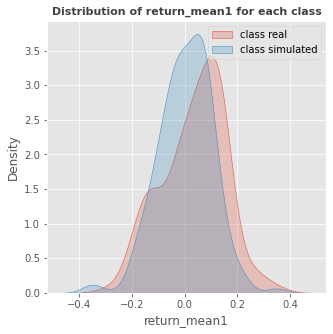

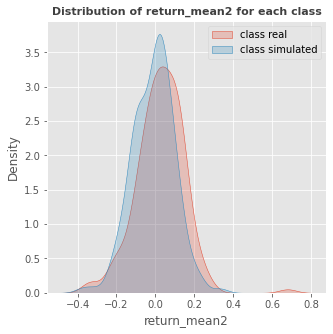

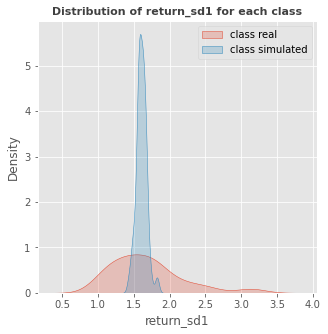

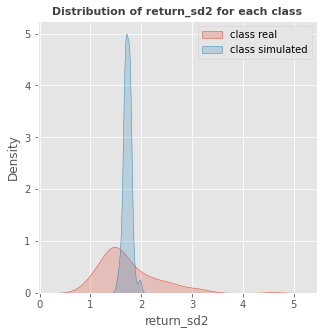

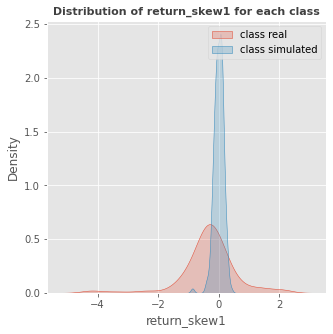

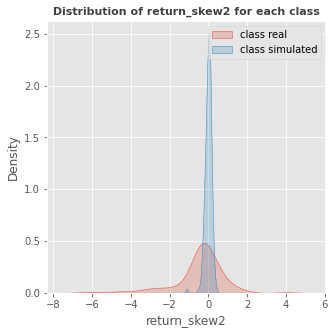

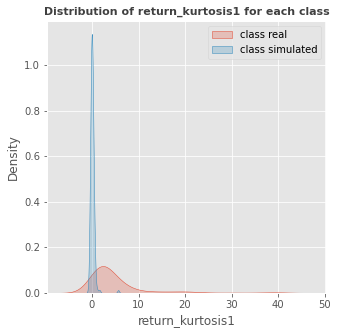

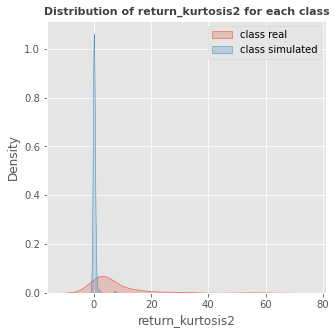

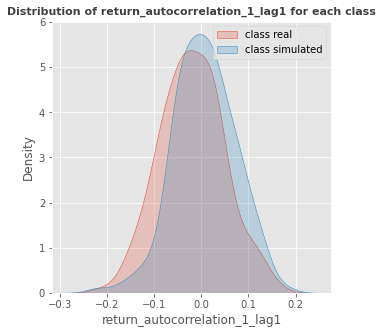

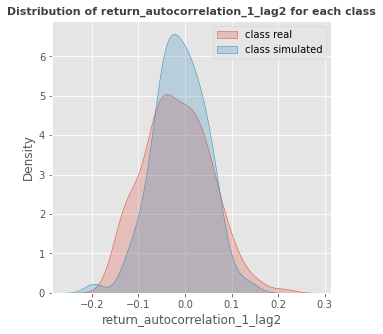

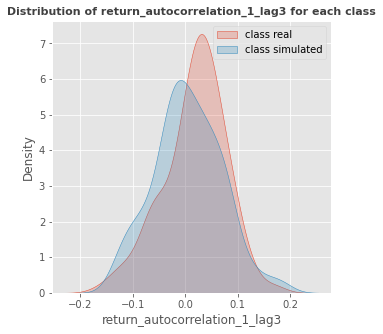

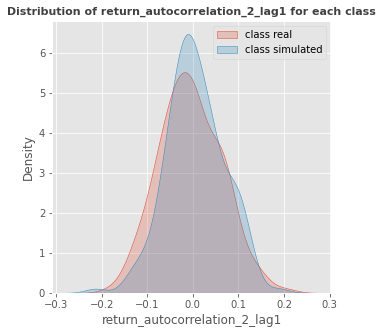

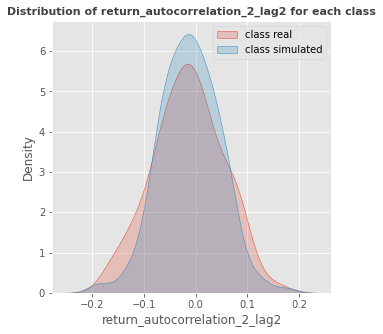

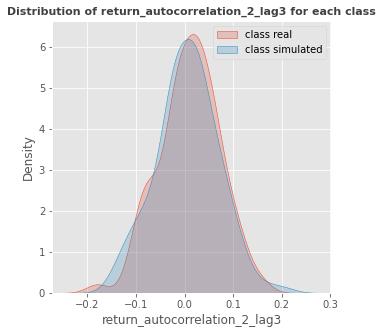

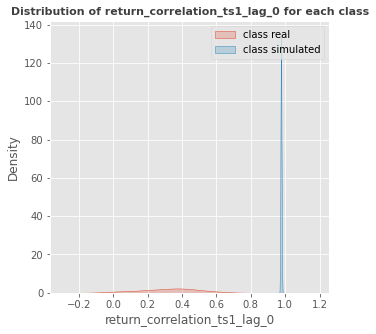

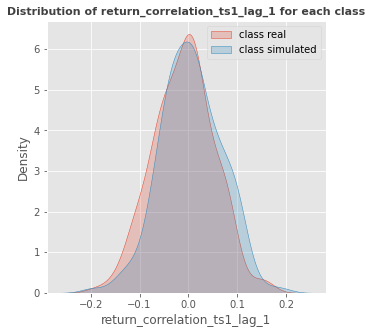

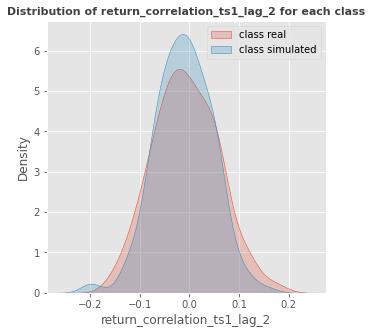

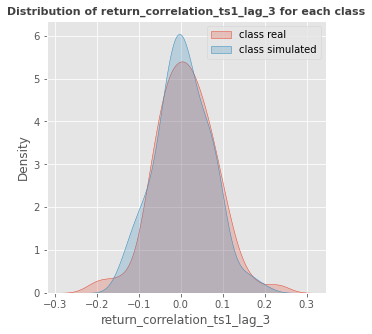

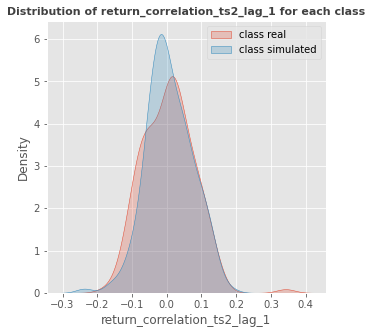

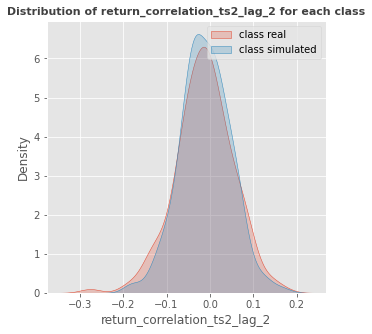

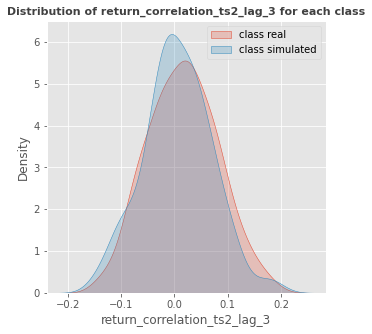

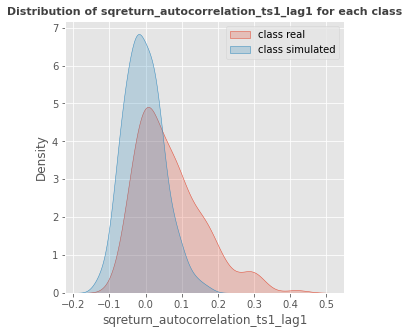

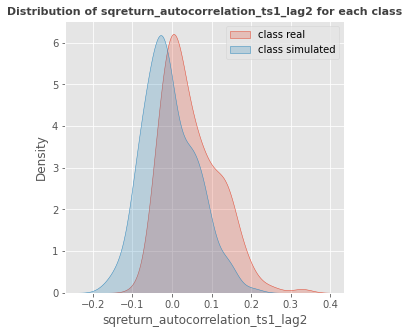

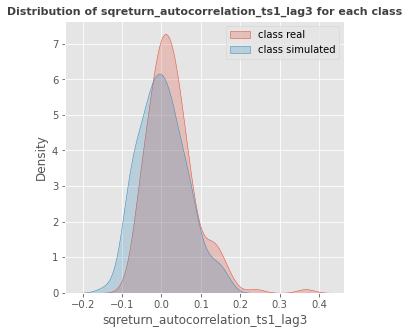

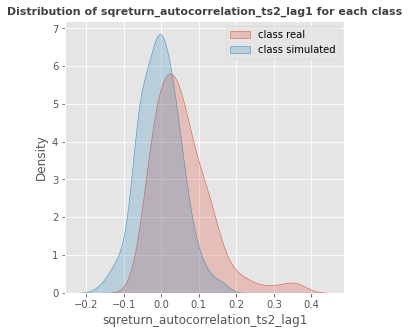

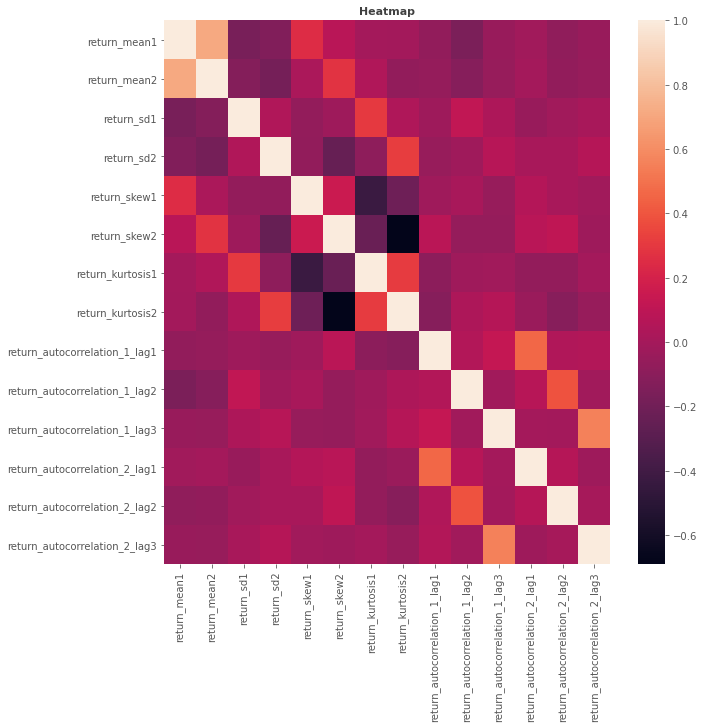

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=mu11, mu12=params[0], 
        mu21=mu21, mu22=params[1], 
        sigma11=params[2], sigma12=params[3], 
        sigma21=params[4], sigma22=params[5],
        j11=params[6], j12=params[7], 
        j21=params[8], j22=params[9],
        alpha=params[10], 
        beta1=beta1, beta2=beta2, 
        delta0=params[11], 
        mu1=params[12], mu2=params[13], 
        lambda11=params[14], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[14],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")



In [5]:
print(results)
print(accuracy_average)
print(accuracy_std)

[1.0, 0.9865771812080537, 0.9932885906040269, 0.9865771812080537, 0.9932885906040269]
0.9919463087248322
0.00502235890842139
